<a href="https://colab.research.google.com/github/znatri/Biologically_Plausible_NN_Learning/blob/main/DFC_NMA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install Package Dependencies
!pip install -q ipympl ipywidgets mpl_interactions["jupyter"] rsatoolbox torchlens
!pip install -q graphviz

!pip install vibecheck numpy matplotlib torch torchvision tqdm ipywidgets memory-profiler requests scikit-learn torchmetrics --quiet

In [2]:
# @title Importing dependencies

from IPython.display import Image, SVG, display
import os
from pathlib import Path
import contextlib
import io
import sys
import warnings

# Import future dependencies
from __future__ import print_function

# Standard library imports
import argparse
import warnings
import logging
from collections import OrderedDict

# Third-party library imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy import stats
import ipywidgets as widgets
from tqdm import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
from torchvision import transforms, datasets
import torchlens as tl
from torchvision.utils import make_grid
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

# scikit-learn imports
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import linear_kernel
from sklearn import manifold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# rsatoolbox imports
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm

# Jupyter-specific imports
%matplotlib inline

In [3]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# @title Plotting functions

# @markdown `sample_images(data_loader, n=5, plot=False)`: Samples a specified number of images per class from a data loader and optionally plots them.
def sample_images(data_loader, n=5, plot=False):
    """
    Samples a specified number of images from a data loader.

    Inputs:
    - data_loader (torch.utils.data.DataLoader): Data loader containing images and labels.
    - n (int): Number of images to sample per class.
    - plot (bool): Whether to plot the sampled images using matplotlib.

    Outpus:
    - imgs (torch.Tensor): Sampled images.
    - labels (torch.Tensor): Corresponding labels for the sampled images.
    """
    with plt.xkcd():
        ########### NEW STUFFF #############################
        imgs_list = []
        labels_list = []

        # Iterate over the data_loader and concatenate batches
        for i, (imgs, labels) in enumerate(data_loader):
            imgs_list.append(imgs)
            labels_list.append(labels)
            if i + 1 >= n:
                break

        # Concatenate all collected batches
        imgs = torch.cat(imgs_list, dim=0)
        labels = torch.cat(labels_list, dim=0)
        #####################################################
        # imgs, labels = next(iter(data_loader))

        imgs_o = []
        targets = []
        for value in range(10):
            imgs_o.append(imgs[np.where(labels == value)][0:n])
            targets.append([value]*n)

        imgs = torch.cat(imgs_o, dim=0)
        targets = torch.tensor(targets).flatten()

        print(f'{len(imgs_o)=}')

        if plot:
            plt.imshow(torch.moveaxis(make_grid(imgs, nrow=5, padding=0, normalize=False, pad_value=0), 0,-1))
            plt.axis('off')

    return imgs, targets


# @markdown `plot_maps(model_features, model_name)`: Plots representational dissimilarity matrices (RDMs) across different layers of a model.
def plot_maps(model_features, model_name):
    """
    Plots representational dissimilarity matrices (RDMs) across different layers of a model.

    Inputs:
    - model_features (dict): a dictionary where keys are layer names and values are numpy arrays representing RDMs for each layer.
    - model_name (str): the name of the model being visualized.
    """
    with plt.xkcd():

        fig = plt.figure(figsize=(14, 4))
        fig.suptitle(f"RDMs across layers for {model_name}")
        # and we add one plot per reference point
        gs = fig.add_gridspec(1, len(model_features))
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        for l in range(len(model_features)):

            layer = list(model_features.keys())[l]
            map_ = np.squeeze(model_features[layer])

            if len(map_.shape) < 2:
                map_ = map_.reshape( (int(np.sqrt(map_.shape[0])), int(np.sqrt(map_.shape[0]))) )

            map_ = map_ / np.max(map_)

            ax = plt.subplot(gs[0,l])
            ax_ = ax.imshow(map_, cmap='magma_r')
            ax.set_title(f'{layer}')
            ax.set_xlabel("input index")
            if l==0:
              ax.set_ylabel("input index")

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
        cbar = fig.colorbar(ax_, cax=cbar_ax)
        cbar.set_label('Dissimilarity', rotation=270, labelpad=15)

        plt.show()

# @title Plotting functions
#@markdown To get started exploring the dataset, here are a few plotting functions:

#@markdown `get_plotting_color()`: Returns a color for the specific dataset, e.g. "train" or model index.
def get_plotting_color(dataset="train", model_idx=None):
  if model_idx is not None:
    dataset = None

  if model_idx == 0 or dataset == "train":
    color = "#1F77B4" # blue
  elif model_idx == 1 or dataset == "valid":
    color = "#FF7F0E" # orange
  elif model_idx == 2 or dataset == "test":
    color = "#2CA02C" # green
  else:
    if model_idx is not None:
      raise NotImplementedError("Colors only implemented for up to 3 models.")
    else:
      raise NotImplementedError(
          f"{dataset} dataset not recognized. Expected 'train', 'valid' "
          "or 'test'."
          )

  return color


#@markdown `plot_examples(subset)`: Plot examples from the dataset organized by their predicted class
#@markdown (if a model is provided) or by their class label otherwise
def plot_examples(subset, num_examples_per_class=8, MLP=None, seed=None,
                  batch_size=32, num_classes=10, ax=None):
  """
  Function for visualizing example images from the dataset, organized by their
  predicted class, if a model is provided, or by their class, otherwise.

  Arguments:
  - subset (torch dataset or torch dataset subset): dataset from which to
    visualized images.
  - num_examples_per_class (int, optional): number of examples to visualize per
    class
  - MLP (MultiLayerPerceptron or None, optional): model to use to retrieve the
    predicted class for each image. If MLP is None, images will be organized by
    their class label. Otherwise, images will be organized by their predicted
    class.
  - seed (int or None, optional): Seed to use to randomly sample images to
    visualize.
  - batch_size (int, optional): If MLP is not None, number of images to
    retrieve predicted class for at one time.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if MLP is None:
    xlabel = "Class"
  else:
    MLP.eval()
    xlabel = "Predicted class"

  if ax is None:
    fig_wid = min(8, num_classes * 0.6)
    fig_hei = min(8, num_examples_per_class * 0.6)
    _, ax = plt.subplots(figsize=(fig_wid, fig_hei))

  if seed is None:
    generator = None
  else:
    generator = torch.Generator()
    generator.manual_seed(seed)

  loader = torch.utils.data.DataLoader(
      subset, batch_size=batch_size, shuffle=True, generator=generator
      )

  plot_images = {i: list() for i in range(num_classes)}
  with torch.no_grad():
    for X, y in loader:
      if MLP is not None:
        y = MLP(X)
        y = torch.argmax(y, axis=1)

      done = True
      for i in range(num_classes):
        num_to_add = int(num_examples_per_class - len(plot_images[i]))
        if num_to_add:
          add_images = np.where(y == i)[0]
          if len(add_images):
            for add_i in add_images[: num_to_add]:
              plot_images[i].append(X[add_i, 0].numpy())
          if len(plot_images[i]) != num_examples_per_class:
            done = False

      if done:
        break

  hei, wid = X[0, 0].shape
  final_image = np.full((num_examples_per_class * hei, num_classes * wid), np.nan)
  for i, images in plot_images.items():
    if len(images):
      final_image[: len(images) * hei, i * wid: (i + 1) * wid] = np.vstack(images)

  ax.imshow(final_image, cmap="gray")

  ax.set_xlabel(xlabel)
  ax.set_xticks((np.arange(num_classes) + 0.5) * wid)
  ax.set_xticklabels([f"{int(i)}" for i in range(num_classes)])
  ax.set_yticks([])
  ax.set_title(f"Examples per {xlabel.lower()}")

  return ax

#@markdown `plot_class_distribution(train_set)`: Plots the distribution of classes in each set (train, validation, test).
def plot_class_distribution(train_set, valid_set=None, test_set=None,
                            num_classes=10, ax=None):
  """
  Function for plotting the number of examples per class in each subset.

  Arguments:
  - train_set (torch dataset or torch dataset subset): training dataset
  - valid_set (torch dataset or torch dataset subset, optional): validation
    dataset
  - test_set (torch dataset or torch dataset subset, optional): test
    dataset
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  bins = np.arange(num_classes + 1) - 0.5

  for dataset_name, dataset in [
      ("train", train_set), ("valid", valid_set), ("test", test_set)
      ]:
    if dataset is None:
      continue

    if hasattr(dataset, "dataset"):
      targets = dataset.dataset.targets[dataset.indices]
    else:
      targets = dataset.targets

    outputs = ax.hist(
        targets,
        bins=bins,
        alpha=0.3,
        color=get_plotting_color(dataset_name),
        label=dataset_name,
        )

    per_class = len(targets) / num_classes
    ax.axhline(
        per_class,
        ls="dashed",
        color=get_plotting_color(dataset_name),
        alpha=0.8
        )

  ax.set_xticks(range(num_classes))
  ax.set_title("Counts per class")
  ax.set_xlabel("Class")
  ax.set_ylabel("Count")
  ax.legend(loc="center right")

  return ax

#@markdown `plot_results(results_dict)`: Plots classification losses and
#@markdown accuracies across epochs for the training and validation sets.
def plot_results(results_dict, num_classes=10, ax=None):
  """
  Function for plotting losses and accuracies across learning.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (float, optional): Number of classes, used to calculate chance
    accuracy.
  - ax (plt subplot, optional): Axis on which to plot results. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which results were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(7, 3.5))

  loss_ax = ax
  acc_ax = None

  chance = 100 / num_classes

  plotted = False
  for result_type in ["losses", "accuracies"]:
    for dataset in ["train", "valid"]:
      key = f"avg_{dataset}_{result_type}"
      if key in results_dict.keys():
        if result_type == "losses":
          ylabel = "Loss"
          plot_ax = loss_ax
          ls = None
        elif result_type == "accuracies":
          if acc_ax is None:
            acc_ax = ax.twinx()
            acc_ax.spines[["right"]].set_visible(True)
            acc_ax.axhline(chance, ls="dashed", color="k", alpha=0.8)
            acc_ax.set_ylim(-5, 105)
          ylabel = "Accuracy (%)"
          plot_ax = acc_ax
          ls = "dashed"
        else:
          raise RuntimeError(f"{result_type} result type not recognized.")

        data = results_dict[key]
        plot_ax.plot(
            data,
            ls=ls,
            label=dataset,
            alpha=0.8,
            color=get_plotting_color(dataset)
            )
        plot_ax.set_ylabel(ylabel)
        plotted = True

  if plotted:
    ax.legend(loc="center left")
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels([f"{int(e)}" for e in range(len(data))])
    ymin, ymax = ax.get_ylim()
    if ymin > 0:
      ymin = 0
      pad = (ymax - ymin) * 0.05
      ax.set_ylim(ymin - pad, ymax + pad)

  else:
    raise RuntimeError("No data found to plot.")

  ax.set_title("Performance across learning")
  ax.set_xlabel("Epoch")

  return ax


#@markdown `plot_scores_per_class(results_dict)`: Plots the classification
#@markdown accuracies by class for the training and validation sets (for the last epoch).
def plot_scores_per_class(results_dict, num_classes=10, ax=None):
  """
  Function for plotting accuracy scores for each class.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot accuracies. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which accuracies were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  avgs = list()
  ax.set_prop_cycle(None) # reset color cycle
  for s, dataset in enumerate(["train", "valid"]):
    correct_by_class = results_dict[f"{dataset}_correct_by_class"]
    seen_by_class = results_dict[f"{dataset}_seen_by_class"]
    xs, ys = list(), list()
    for i, total in seen_by_class.items():
      xs.append(i + 0.3 * (s - 0.5))
      if total == 0:
        ys.append(np.nan)
      else:
        ys.append(100 * correct_by_class[i] / total)

    avg_key = f"avg_{dataset}_accuracies"
    if avg_key in results_dict.keys():
      ax.axhline(
          results_dict[avg_key][-1], ls="dashed", alpha=0.8,
          color=get_plotting_color(dataset)
          )

    ax.bar(
        xs, ys, label=dataset, width=0.3, alpha=0.8,
        color=get_plotting_color(dataset)
        )

  ax.set_xticks(range(num_classes))
  ax.set_xlabel("Class")
  ax.set_ylabel("Accuracy (%)")
  ax.set_title("Class scores")
  ax.set_ylim(-5, 105)

  chance = 100 / num_classes
  ax.axhline(chance, ls="dashed", color="k", alpha=0.8)

  ax.legend()

  return ax


#@markdown `plot_weights(MLP)`: Plots weights before and after training.
def plot_weights(MLP, shared_colorbar=False):
  """
  Function for plotting model weights and biases before and after learning.

  Arguments:
  - MLP (torch model): Model for which to plot weights and biases.
  - shared_colorbar (bool, optional): If True, one colorbar is shared for all
      parameters.

  Returns:
  - ax (plt subplot array): Axes on which weights and biases were plotted.
  """

  param_names = MLP.list_parameters()

  params_images = dict()
  pre_means = dict()
  post_means = dict()
  vmin, vmax = np.inf, -np.inf
  for param_name in param_names:
    layer, param_type = param_name.split("_")
    init_params = getattr(MLP, f"init_{layer}_{param_type}").numpy()
    separator = np.full((1, init_params.shape[-1]), np.nan)
    last_params = getattr(getattr(MLP, layer), param_type).detach().numpy()
    diff_params = last_params - init_params

    params_image = np.vstack(
        [init_params, separator, last_params, separator, diff_params]
        )
    vmin = min(vmin, np.nanmin(params_image))
    vmax = min(vmax, np.nanmax(params_image))

    params_images[param_name] = params_image
    pre_means[param_name] = init_params.mean()
    post_means[param_name] = last_params.mean()

  nrows = len(param_names)
  gridspec_kw = dict()
  if len(param_names) == 4:
    gridspec_kw["height_ratios"] = [5, 1, 5, 1]
    cbar_label = "Weight/bias values"
  elif len(param_names) == 2:
    gridspec_kw["height_ratios"] = [5, 5]
    cbar_label = "Weight values"
  else:
    raise NotImplementedError("Expected 2 parameters (weights only) or "
      f"4 parameters (weights and biases), but found {len(param_names)}"
    )

  if shared_colorbar:
    nrows += 1
    gridspec_kw["height_ratios"].append(1)
  else:
    vmin, vmax = None, None

  fig, axes = plt.subplots(
      nrows, 1, figsize=(6, nrows + 3), gridspec_kw=gridspec_kw
      )

  for i, (param_name, params_image) in enumerate(params_images.items()):
    layer, param_type = param_name.split("_")
    layer_str = "First" if layer == "lin1" else "Second"
    param_str = "weights" if param_type == "weight" else "biases"

    axes[i].set_title(f"{layer_str} linear layer {param_str} (pre, post and diff)")
    im = axes[i].imshow(params_image, aspect="auto", vmin=vmin, vmax=vmax)
    if not shared_colorbar:
      cbar = fig.colorbar(im, ax=axes[i], aspect=10)
      cbar.ax.axhline(pre_means[param_name], ls="dotted", color="k", alpha=0.5)
      cbar.ax.axhline(post_means[param_name], color="k", alpha=0.5)

    if param_type == "weight":
      axes[i].set_xlabel("Input dim.")
      axes[i].set_ylabel("Output dim.")
    axes[i].spines[["left", "bottom"]].set_visible(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

  if shared_colorbar:
    cax = axes[-1]
    cbar = fig.colorbar(im, cax=cax, orientation="horizontal", location="bottom")
    cax.set_xlabel(cbar_label)

  return axes

# @markdown `plot_dim_reduction(model_features, labels, transformer_funcs)`: Plots the dimensionality reduction results for model features using various transformers (PCA, MDS, t-SNE).
def plot_dim_reduction(model_features, labels, transformer_funcs):
    """
    Plots the dimensionality reduction results for model features using various transformers.

    Inputs:
    - model_features (dict): Dictionary containing model features for each layer.
    - labels (array-like): Array of labels corresponding to the model features.
    - transformer_funcs (list): List of dimensionality reduction techniques to apply ('PCA', 'MDS', 't-SNE').
    """
    with plt.xkcd():

        transformers = []
        for t in transformer_funcs:
            if t == 'PCA': transformers.append(PCA(n_components=2))
            if t == 'MDS': transformers.append(manifold.MDS(n_components = 2, normalized_stress='auto'))
            if t == 't-SNE': transformers.append(manifold.TSNE(n_components = 2, perplexity=40, verbose=0))

        fig = plt.figure(figsize=(8, 2.5*len(transformers)))
        # and we add one plot per reference point
        gs = fig.add_gridspec(len(transformers), len(model_features))
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        return_layers = list(model_features.keys())

        for f in range(len(transformer_funcs)):

            for l in range(len(return_layers)):
                layer =  return_layers[l]
                feats = model_features[layer].detach().cpu().flatten(1)
                feats_transformed= transformers[f].fit_transform(feats)

                amin, amax = feats_transformed.min(), feats_transformed.max()
                amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8
                ax = plt.subplot(gs[f,l])
                ax.set_xlim([amin, amax])
                ax.set_ylim([amin, amax])
                ax.axis("off")
                #ax.set_title(f'{layer}')
                if f == 0: ax.text(0.5, 1.12, f'{layer}', size=16, ha="center", transform=ax.transAxes)
                if l == 0: ax.text(-0.3, 0.5, transformer_funcs[f], size=16, ha="center", transform=ax.transAxes)
                # Create a discrete color map based on unique labels
                num_colors = len(np.unique(labels))
                cmap = plt.get_cmap('viridis_r', num_colors) # 10 discrete colors
                norm = mpl.colors.BoundaryNorm(np.arange(-0.5,num_colors), cmap.N)
                ax_ = ax.scatter(feats_transformed[:, 0], feats_transformed[:, 1], c=labels, cmap=cmap, norm=norm)

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
        fig.colorbar(ax_, cax=cbar_ax, ticks=np.linspace(0,9,10))
        plt.show()

#@markdown `plot_progress(results_dict)`: Visualizes the training progress.
#@markdown Creates two subplots: one for loss and one for accuracy, both showing
#@markdown training and validation metrics over epochs.
def plot_progress(results_dict):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(results_dict["avg_train_losses"], label="Train")
    plt.plot(results_dict["avg_valid_losses"], label="Validation")
    plt.title("Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(results_dict["avg_train_accuracies"], label="Train")
    plt.plot(results_dict["avg_valid_accuracies"], label="Validation")
    plt.title("Accuracy over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
# @title Helper Functions

# @markdown `fgsm_attack(image, epsilon, data_grad)`: Performs FGSM attack on an image.
def fgsm_attack(image, epsilon, data_grad):
    """
    Performs FGSM attack on an image.

    Inputs:
    - image (torch.Tensor): Original image.
    - epsilon (float): Perturbation magnitude.
    - data_grad (torch.Tensor): Gradient of the data.

    Outputs:
    - perturbed_image (torch.Tensor): Perturbed image after FGSM attack.
    """
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# @markdown `denorm(batch, mean=[0.1307], std=[0.3081])`: Converts a batch of normalized tensors to their original scale.
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Converts a batch of normalized tensors to their original scale.

    Inputs:
    - batch (torch.Tensor): Batch of normalized tensors.
    - mean (torch.Tensor or list): Mean used for normalization.
    - std (torch.Tensor or list): Standard deviation used for normalization.

    Outputs:
    - torch.Tensor: Batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(batch.device)
    if isinstance(std, list):
        std = torch.tensor(std).to(batch.device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

# @markdown `generate_adversarial(model, imgs, targets, epsilon)`: Generates adversarial examples using FGSM attack.
def generate_adversarial(model, imgs, targets, epsilon):
    """
    Generates adversarial examples using FGSM attack.

    Inputs:
    - model (torch.nn.Module): The model to attack.
    - imgs (torch.Tensor): Batch of images.
    - targets (torch.Tensor): Batch of target labels.
    - epsilon (float): Perturbation magnitude.

    Outputs:
    - adv_imgs (torch.Tensor): Batch of adversarial images.
    """
    adv_imgs = []
    print(f'{imgs.shape=}')
    for img, target in zip(imgs, targets):
        img = img.unsqueeze(0)
        target = target.unsqueeze(0)
        img.requires_grad = True

        output = model(img)
        loss = F.nll_loss(output, target)

        model.zero_grad()
        loss.backward()

        data_grad = img.grad.data
        data_denorm = denorm(img)
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        adv_imgs.append(perturbed_data_normalized.detach())

    return torch.cat(adv_imgs)

# @markdown `test_adversarial(model, imgs, targets)`: Tests the model on adversarial examples and prints the accuracy.
def test_adversarial(model, imgs, targets):
    """
    Tests the model on adversarial examples and prints the accuracy.

    Inputs:
    - model (torch.nn.Module): The model to be tested.
    - imgs (torch.Tensor): Batch of adversarial images.
    - targets (torch.Tensor): Batch of target labels.
    """
    correct = 0
    output = model(imgs)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(targets.view_as(pred)).sum().item()

    final_acc = correct / float(len(imgs))
    print(f"adversarial test accuracy = {correct} / {len(imgs)} = {final_acc}")

# @markdown `extract_features(model, imgs, return_layers, plot='none')`: Extracts features from specified layers of the model.
def extract_features(model, imgs, return_layers, plot='none'):
    """
    Extracts features from specified layers of the model.

    Inputs:
    - model (torch.nn.Module): The model from which to extract features.
    - imgs (torch.Tensor): Batch of input images.
    - return_layers (list): List of layer names from which to extract features.
    - plot (str): Option to plot the features. Default is 'none'.

    Outputs:
    - model_features (dict): A dictionary with layer names as keys and extracted features as values.
    """
    model_history = tl.log_forward_pass(model, imgs, layers_to_save='all', vis_opt=plot)
    model_features = {}
    for layer in return_layers:
        model_features[layer] = model_history[layer].tensor_contents.flatten(1)

    return model_features

# @markdown `print_results_by_class(results_dict, dataset="train")`: Prints results by class from a results dictionary.
def print_results_by_class(results_dict, dataset="train"):
  """
  Prints results by class from a results dictionary.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - dataset (str, optional): Dataset to print results for.
  """

  print(f"Results by class ({dataset} set):")
  for i in range(MLP.num_outputs):
    num_correct = results_dict[f"{dataset}_correct_by_class"][i]
    num_seen = results_dict[f"{dataset}_seen_by_class"][i]
    if num_seen > 0:
      acc = num_correct / num_seen * 100
    else:
      acc = 0
    print(f"  Class {i}: {acc:.2f}% ({num_correct}/{num_seen})")

# @markdown `test_model(MLP, test_loader)`: Tests a model on a test set.
def test_model(MLP, test_loader):
  """
  Tests a model on a test set.

  Arguments:
  - MLP (torch model): Model to test.
  - test_loader (torch dataloader): Dataloader to use to test the model.

  Returns:
  - test_acc (float): Test accuracy.
  """

  MLP.eval()
  test_acc = list()
  with torch.no_grad():
    for X, y in test_loader:
      y_pred = MLP(X)
      acc = (torch.argmax(y_pred, axis=1) == y).sum() / len(y)
      test_acc.append(acc.item() * len(y))

  test_acc = np.sum(test_acc) / len(test_loader.dataset) * 100
  print(f"Test accuracy: {test_acc:.2f}%")
  return test_acc

#@markdown `update_results_by_class_in_place(y, y_pred, result_dict, dataset, num_classes)`:
#@markdown Updates the results dictionary with per-class accuracy information.
#@markdown This function is called during training to keep track of model performance for each class.
def update_results_by_class_in_place(y, y_pred, result_dict, dataset="train",
                                     num_classes=10):
    y_pred = np.argmax(y_pred, axis=1)
    if len(y) != len(y_pred):
        raise RuntimeError("Number of predictions does not match number of targets.")

    for i in result_dict[f"{dataset}_seen_by_class"].keys():
        idxs = np.where(y == int(i))[0]
        result_dict[f"{dataset}_seen_by_class"][int(i)] += len(idxs)

        num_correct = int(sum(y[idxs] == y_pred[idxs]))
        result_dict[f"{dataset}_correct_by_class"][int(i)] += num_correct


In [6]:
# @title Download Datasets

# @markdown `download_mnist()`: Function to download MNIST.
def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output

      full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform
          )
      full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform
          )

  train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set,
      [train_prop * keep_prop, valid_prop * keep_prop, discard_prop]
      )
  test_set, _ = torch.utils.data.random_split(
      full_test_set,
      [keep_prop, discard_prop]
      )

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set

# @markdown `download_cifar10()`: Function to download CIFAR-10.
def download_cifar10(train_prop=0.8, keep_prop=0.5):
    """
    Downloads the CIFAR-10 dataset and splits it into training, validation, and test sets.

    Arguments:
    - train_prop (float, optional): Proportion of training data in the full training set (default is 0.8).
    - keep_prop (float, optional): Proportion of data to keep (default is 0.5).

    Returns:
    - train_set (torch.utils.data.Dataset): Training set.
    - valid_set (torch.utils.data.Dataset): Validation set.
    - test_set (torch.utils.data.Dataset): Test set.
    """
    valid_prop = 1 - train_prop
    discard_prop = 1 - keep_prop

    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
    )

    with contextlib.redirect_stdout(io.StringIO()):  # to suppress output
        full_train_set = torchvision.datasets.CIFAR10(
            root="./data/", train=True, download=True, transform=transform
        )
        full_test_set = torchvision.datasets.CIFAR10(
            root="./data/", train=False, download=True, transform=transform
        )

    # Calculate lengths for splits
    total_train_size = len(full_train_set)
    total_test_size = len(full_test_set)

    train_size = int(train_prop * keep_prop * total_train_size)
    valid_size = int(valid_prop * keep_prop * total_train_size)
    discard_train_size = total_train_size - train_size - valid_size

    test_size = int(keep_prop * total_test_size)
    discard_test_size = total_test_size - test_size

    train_set, valid_set, _ = torch.utils.data.random_split(
        full_train_set,
        [train_size, valid_size, discard_train_size]
    )
    test_set, _ = torch.utils.data.random_split(
        full_test_set,
        [test_size, discard_test_size]
    )

    print("Number of examples retained:")
    print(f"  {len(train_set)} (training)")
    print(f"  {len(valid_set)} (validation)")
    print(f"  {len(test_set)} (test)")

    return train_set, valid_set, test_set

print("Downloading MNIST...")
train_set, valid_set, test_set = download_mnist()

Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


### Define MultiLayerPerceptron

In [7]:
# @title MultiLayerPerceptron Class

# @markdown Choose the dataset:
DATASET = "MNIST"  # @param ["MNIST", "CIFAR-10"]

if DATASET == "MNIST":
    NUM_INPUTS = 28 * 28  # MNIST image size
    NUM_OUTPUTS = 10  # MNIST classes
elif DATASET == "CIFAR-10":
    NUM_INPUTS = 32 * 32 * 3  # CIFAR-10 image size (3 color channels)
    NUM_OUTPUTS = 10  # CIFAR-10 classes
else:
    raise ValueError(f"Unsupported dataset: {DATASET}")

class MultiLayerPerceptron(torch.nn.Module):
    """
    A simple multilayer perceptron model with one hidden layer.
    This class implements a feedforward neural network for classification tasks.
    """

    def __init__(
        self,
        num_inputs=NUM_INPUTS,
        num_hidden=100,
        num_outputs=NUM_OUTPUTS,
        activation_type="sigmoid",
        bias=False,
    ):
        """
        Initializes a multilayer perceptron with a single hidden layer.

        Args:
            num_inputs (int): Number of input units (i.e., flattened image size).
            num_hidden (int): Number of hidden units in the hidden layer.
            num_outputs (int): Number of output units (i.e., number of classes).
            activation_type (str): Type of activation to use for the hidden layer.
                                   Options: 'sigmoid', 'tanh', 'relu', or 'linear'.
            bias (bool): If True, each linear layer will have biases in addition to weights.
        """
        super().__init__()

        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.activation_type = activation_type.lower()
        self.bias = bias

        # Initialize layers
        self.lin1 = torch.nn.Linear(num_inputs, num_hidden, bias=bias)
        self.lin2 = torch.nn.Linear(num_hidden, num_outputs, bias=bias)

        self._store_initial_weights_biases()
        self._set_activation()  # activation on the hidden layer
        self.softmax = torch.nn.Softmax(dim=1)  # activation on the output layer

    def _store_initial_weights_biases(self):
        """Stores a copy of the network's initial weights and biases."""
        self.init_lin1_weight = self.lin1.weight.data.clone()
        self.init_lin2_weight = self.lin2.weight.data.clone()
        if self.bias:
            self.init_lin1_bias = self.lin1.bias.data.clone()
            self.init_lin2_bias = self.lin2.bias.data.clone()

    def _set_activation(self):
        """Sets the activation function used for the hidden layer."""
        activation_functions = {
            "sigmoid": torch.nn.Sigmoid(),  # maps to [0, 1]
            "tanh": torch.nn.Tanh(),  # maps to [-1, 1]
            "relu": torch.nn.ReLU(),  # maps to non-negative values
            "linear": torch.nn.Identity(),  # no activation (identity function)
        }

        self.activation = activation_functions.get(self.activation_type)
        if self.activation is None:
            raise ValueError(f"Unsupported activation type: {self.activation_type}")

    def forward(self, X, y=None):
        """
        Performs a forward pass through the network.

        Args:
            X (torch.Tensor): Batch of input images.
            y (torch.Tensor, optional): Batch of targets. Not used in forward pass,
                                        but included for compatibility with other learning rules.

        Returns:
            torch.Tensor: Predicted class probabilities.
        """
        h = self.activation(self.lin1(X.view(-1, self.num_inputs)))
        y_pred = self.softmax(self.lin2(h))
        return y_pred

    def forward_backprop(self, X):
        """
        Identical to forward(). Used for gradient comparison with other learning rules.
        This method should not be overwritten in child classes.

        Args:
            X (torch.Tensor): Batch of input images.

        Returns:
            torch.Tensor: Predicted class probabilities.
        """
        return self.forward(X)

    def list_parameters(self):
        """
        Returns a list of model parameter names.

        Returns:
            list: List of parameter names.
        """
        params_list = ['lin1_weight', 'lin2_weight']
        if self.bias:
            params_list.extend(['lin1_bias', 'lin2_bias'])
        return params_list

    def gather_gradient_dict(self):
        """
        Gathers gradients for the model's parameters.

        Returns:
            dict: A dictionary of gradients for each parameter.

        Raises:
            RuntimeError: If any parameter has no gradient.
        """
        gradient_dict = {}
        for param_name in self.list_parameters():
            layer_name, param_type = param_name.split('_')
            layer = getattr(self, layer_name)
            grad = getattr(layer, param_type).grad
            if grad is None:
                raise RuntimeError(f"No gradient computed for {param_name}")
            gradient_dict[param_name] = grad.detach().clone().numpy()
        return gradient_dict

In [8]:
# @title Initialize MultiLayerPerceptron
# @markdown Set the model parameters:
NUM_HIDDEN = 100  # @param {type:"integer"}
ACTIVATION_TYPE = "sigmoid"  # @param ["sigmoid", "tanh", "relu", "linear"]
USE_BIAS = False  # @param {type:"boolean"}

# Initialize the model
MLP = MultiLayerPerceptron(
    num_inputs=NUM_INPUTS,
    num_hidden=NUM_HIDDEN,
    num_outputs=NUM_OUTPUTS,
    activation_type=ACTIVATION_TYPE,
    bias=USE_BIAS
)

print(f"Model initialized for {DATASET} dataset")
print(f"Input size: {NUM_INPUTS}")
print(f"Hidden layer size: {NUM_HIDDEN}")
print(f"Output size: {NUM_OUTPUTS}")
print(f"Activation function: {ACTIVATION_TYPE}")
print(f"Using bias: {USE_BIAS}")

train_nodes, _ = get_graph_node_names(MLP)
print(f"Model parameters: {train_nodes}")

# Dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Model initialized for MNIST dataset
Input size: 784
Hidden layer size: 100
Output size: 10
Activation function: sigmoid
Using bias: False
Model parameters: ['x', 'y', 'view', 'lin1', 'activation', 'lin2', 'softmax']


In [9]:
# @title BasicOptimizer

class BasicOptimizer(torch.optim.Optimizer):
    """
    A simple optimizer class based on the Stochastic Gradient Descent (SGD) algorithm.
    This optimizer supports basic parameter updates with learning rate and weight decay.
    """

    def __init__(self, params, lr=0.01, weight_decay=0):
        """
        Initializes the BasicOptimizer.

        Args:
            params (iterable): An iterable of torch.Tensor s or dict s.
                               Specifies what Tensors should be optimized.
            lr (float, optional): Learning rate (default: 0.01)
            weight_decay (float, optional): Weight decay (L2 penalty) (default: 0)

        Raises:
            ValueError: If learning rate or weight decay is negative.
        """
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")

        defaults = dict(lr=lr, weight_decay=weight_decay)
        super().__init__(params, defaults)

    def step(self):
        """
        Performs a single optimization step.

        This method updates all the parameters managed by the optimizer
        based on the current gradients and the optimizer's settings.
        """
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue

                grad = p.grad

                # Apply weight decay to the gradient if specified
                if group["weight_decay"] != 0:
                    grad = grad.add(p, alpha=group["weight_decay"])

                # Update the parameter using gradient descent
                p.data.add_(grad, alpha=-group["lr"])

        return None

In [10]:
# @title Initialize Optimizer

# @markdown This cell initializes the BasicOptimizer for our MLP model.

# Define the learning rate
LR = 0.01  # @param {type:"number"}

# @markdown You can adjust the learning rate above. A higher learning rate may lead to faster training, but could also cause instability.

# Initialize the BasicOptimizer
backprop_optimizer = BasicOptimizer(MLP.parameters(), lr=LR)

# Print optimizer details
print(f"Optimizer: BasicOptimizer")
print(f"Learning rate: {LR}")
print(f"Number of parameter groups: {len(backprop_optimizer.param_groups)}")
total_params = sum(p.numel() for group in backprop_optimizer.param_groups for p in group['params'])
print(f"Total parameters being optimized: {total_params}")

# Optionally, you can add a weight decay parameter
WEIGHT_DECAY = 0.0001  # @param {type:"number"}
backprop_optimizer = BasicOptimizer(MLP.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
print(f"Weight decay: {WEIGHT_DECAY}")

Optimizer: BasicOptimizer
Learning rate: 0.01
Number of parameter groups: 1
Total parameters being optimized: 79400
Weight decay: 0.0001


### Train and Test the MLP model

In [11]:
# @title Training Helper Functions
#@markdown `train_model(MLP, train_loader, valid_loader, optimizer)`: Main function.
#@markdown Trains the model across epochs. Aggregates loss and accuracy statistics
#@markdown from the training and validation datasets into a results dictionary which is returned.
def train_model(MLP, train_loader, valid_loader, optimizer, num_epochs=5):
    results_dict = {
        "avg_train_losses": [],
        "avg_valid_losses": [],
        "avg_train_accuracies": [],
        "avg_valid_accuracies": [],
    }

    for e in tqdm(range(num_epochs), desc="Epochs"):
        no_train = e == 0  # to get a baseline
        latest_epoch_results_dict = train_epoch(
            MLP, train_loader, valid_loader, optimizer=optimizer, no_train=no_train
        )

        for key, result in latest_epoch_results_dict.items():
            if key in results_dict.keys() and isinstance(results_dict[key], list):
                results_dict[key].append(latest_epoch_results_dict[key])
            else:
                results_dict[key] = result  # copy latest

        # Plot progress after each epoch
        plot_progress(results_dict)

    return results_dict

#@markdown `train_epoch(MLP, train_loader, valid_loader, optimizer)`: Trains the model for one epoch.
#@markdown Performs forward and backward passes, updates model parameters, and computes
#@markdown loss and accuracy for both training and validation datasets.
def train_epoch(MLP, train_loader, valid_loader, optimizer, no_train=False):
    criterion = torch.nn.NLLLoss()

    epoch_results_dict = {}
    for dataset in ["train", "valid"]:
        for sub_str in ["correct_by_class", "seen_by_class"]:
            epoch_results_dict[f"{dataset}_{sub_str}"] = {
                i: 0 for i in range(MLP.num_outputs)
            }

    MLP.train()
    train_losses, train_acc = [], []
    for X, y in train_loader:
        y_pred = MLP(X, y=y)
        loss = criterion(torch.log(y_pred), y)
        acc = (torch.argmax(y_pred.detach(), axis=1) == y).sum() / len(y)
        train_losses.append(loss.item() * len(y))
        train_acc.append(acc.item() * len(y))
        update_results_by_class_in_place(
            y, y_pred.detach(), epoch_results_dict, dataset="train",
            num_classes=MLP.num_outputs
        )
        optimizer.zero_grad()
        if not no_train:
            loss.backward()
            optimizer.step()

    num_items = len(train_loader.dataset)
    epoch_results_dict["avg_train_losses"] = np.sum(train_losses) / num_items
    epoch_results_dict["avg_train_accuracies"] = np.sum(train_acc) / num_items * 100

    MLP.eval()
    valid_losses, valid_acc = [], []
    with torch.no_grad():
        for X, y in valid_loader:
            y_pred = MLP(X)
            loss = criterion(torch.log(y_pred), y)
            acc = (torch.argmax(y_pred, axis=1) == y).sum() / len(y)
            valid_losses.append(loss.item() * len(y))
            valid_acc.append(acc.item() * len(y))
            update_results_by_class_in_place(
                y, y_pred.detach(), epoch_results_dict, dataset="valid"
            )

    num_items = len(valid_loader.dataset)
    epoch_results_dict["avg_valid_losses"] = np.sum(valid_losses) / num_items
    epoch_results_dict["avg_valid_accuracies"] = np.sum(valid_acc) / num_items * 100

    return epoch_results_dict


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

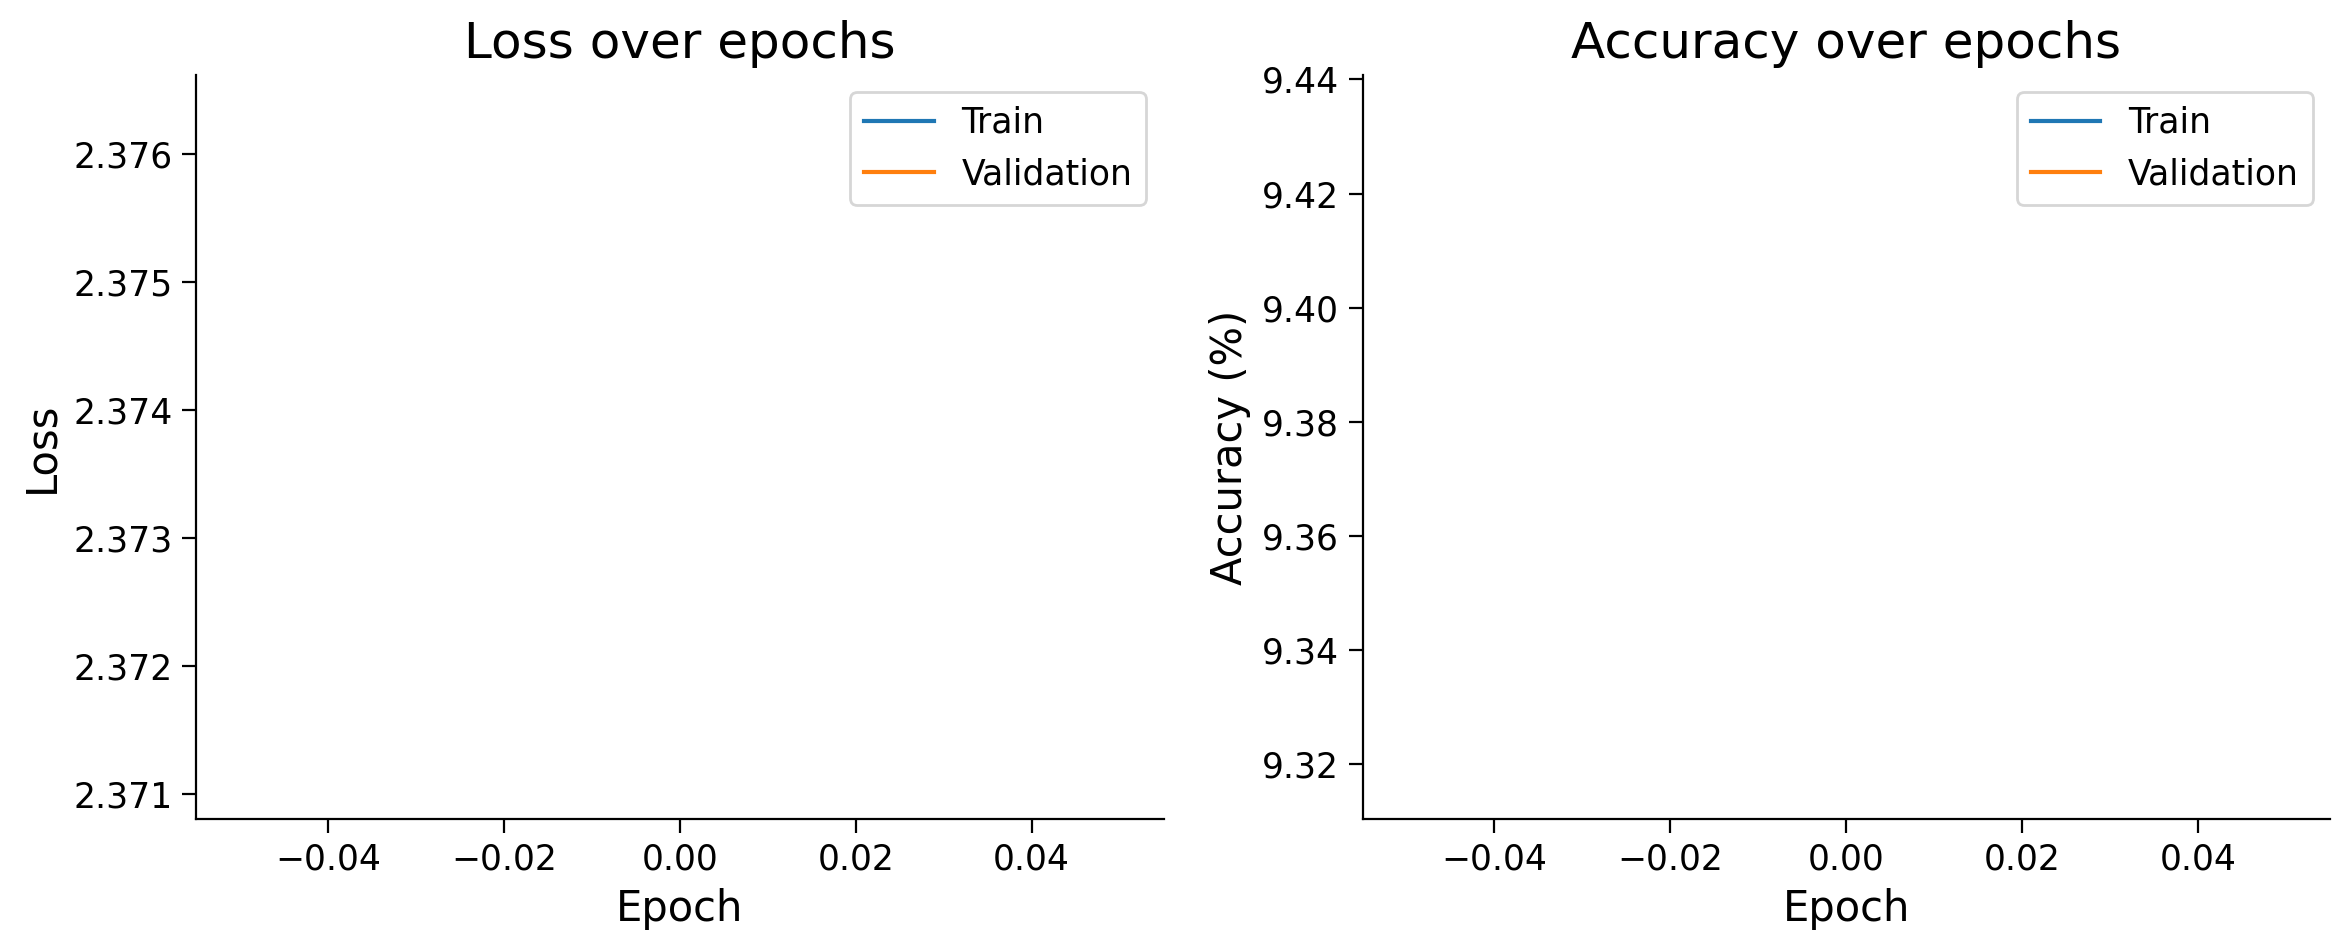

Epochs:  20%|██        | 1/5 [00:20<01:22, 20.69s/it]

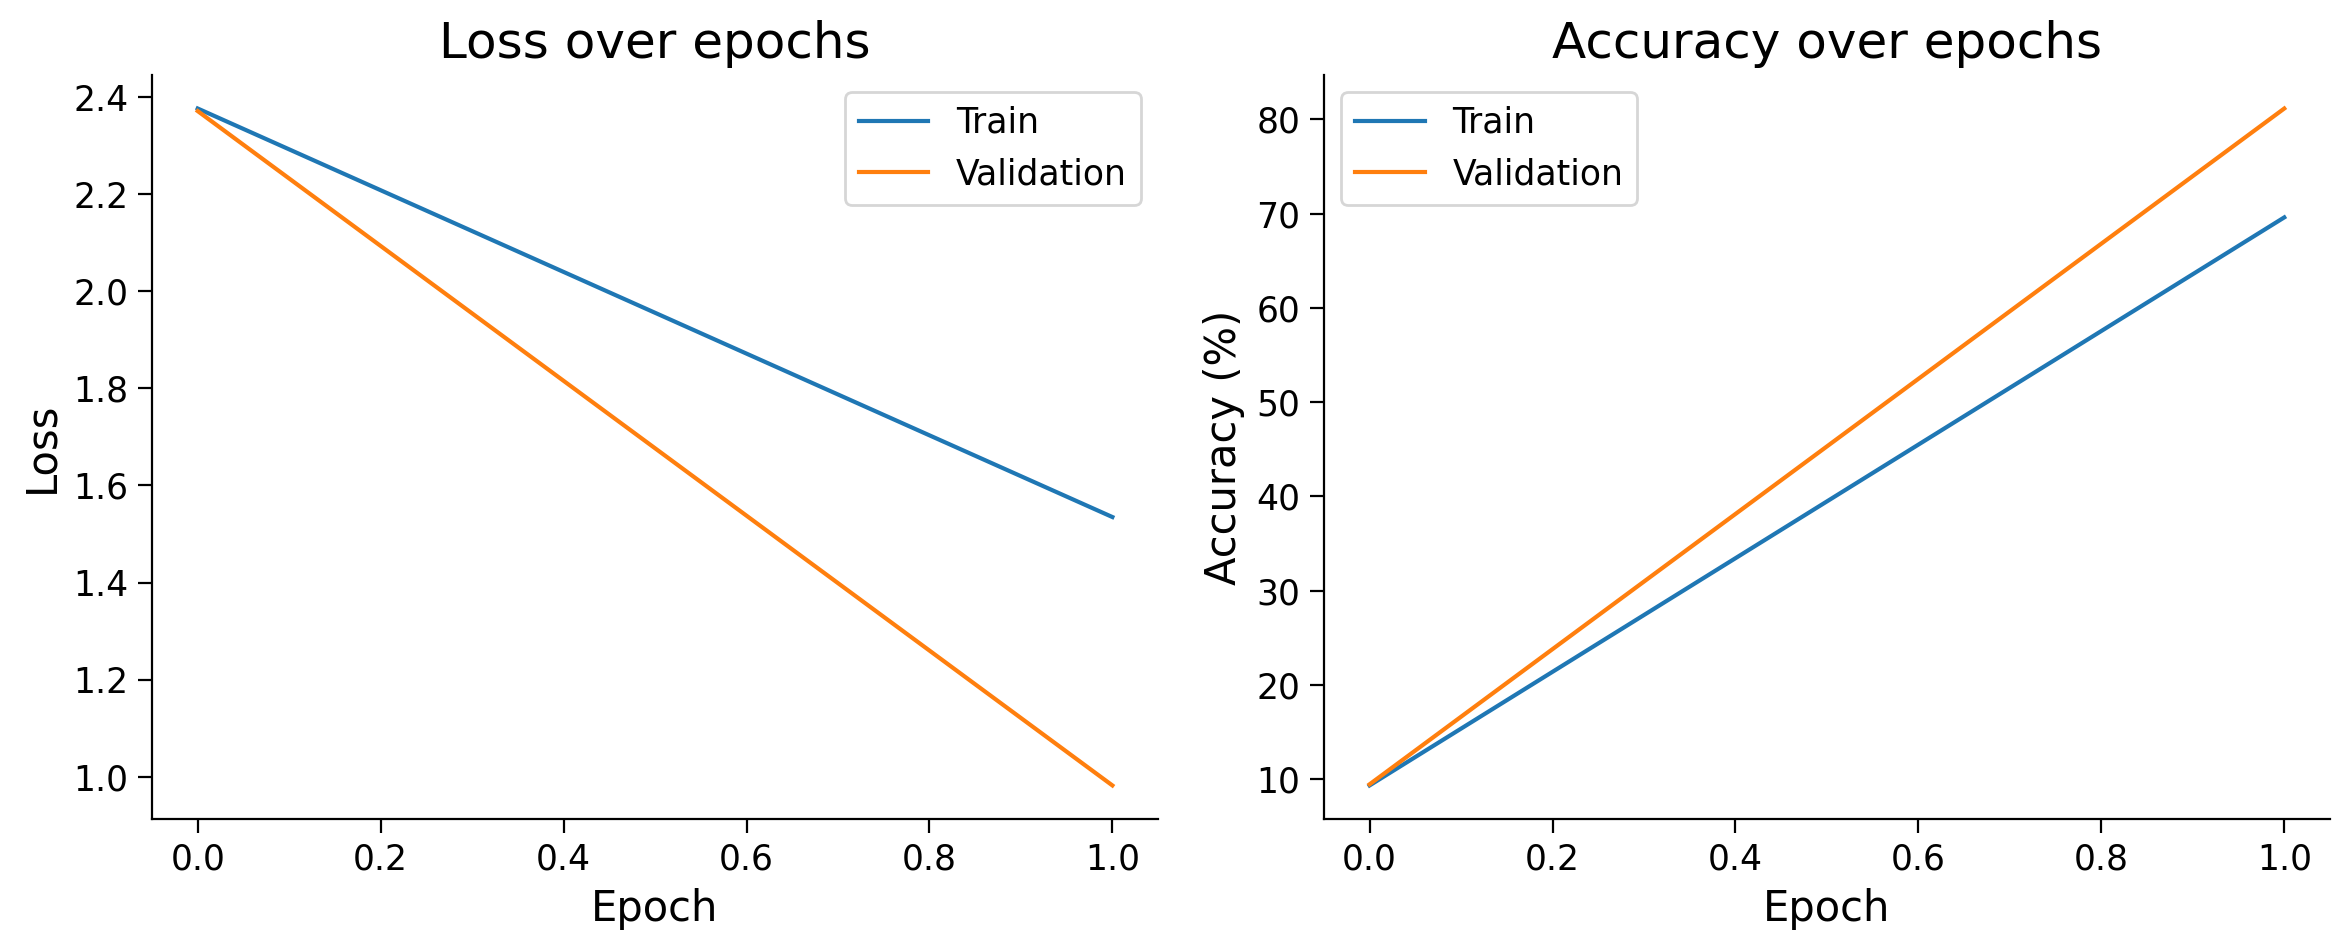

Epochs:  40%|████      | 2/5 [00:30<00:43, 14.37s/it]

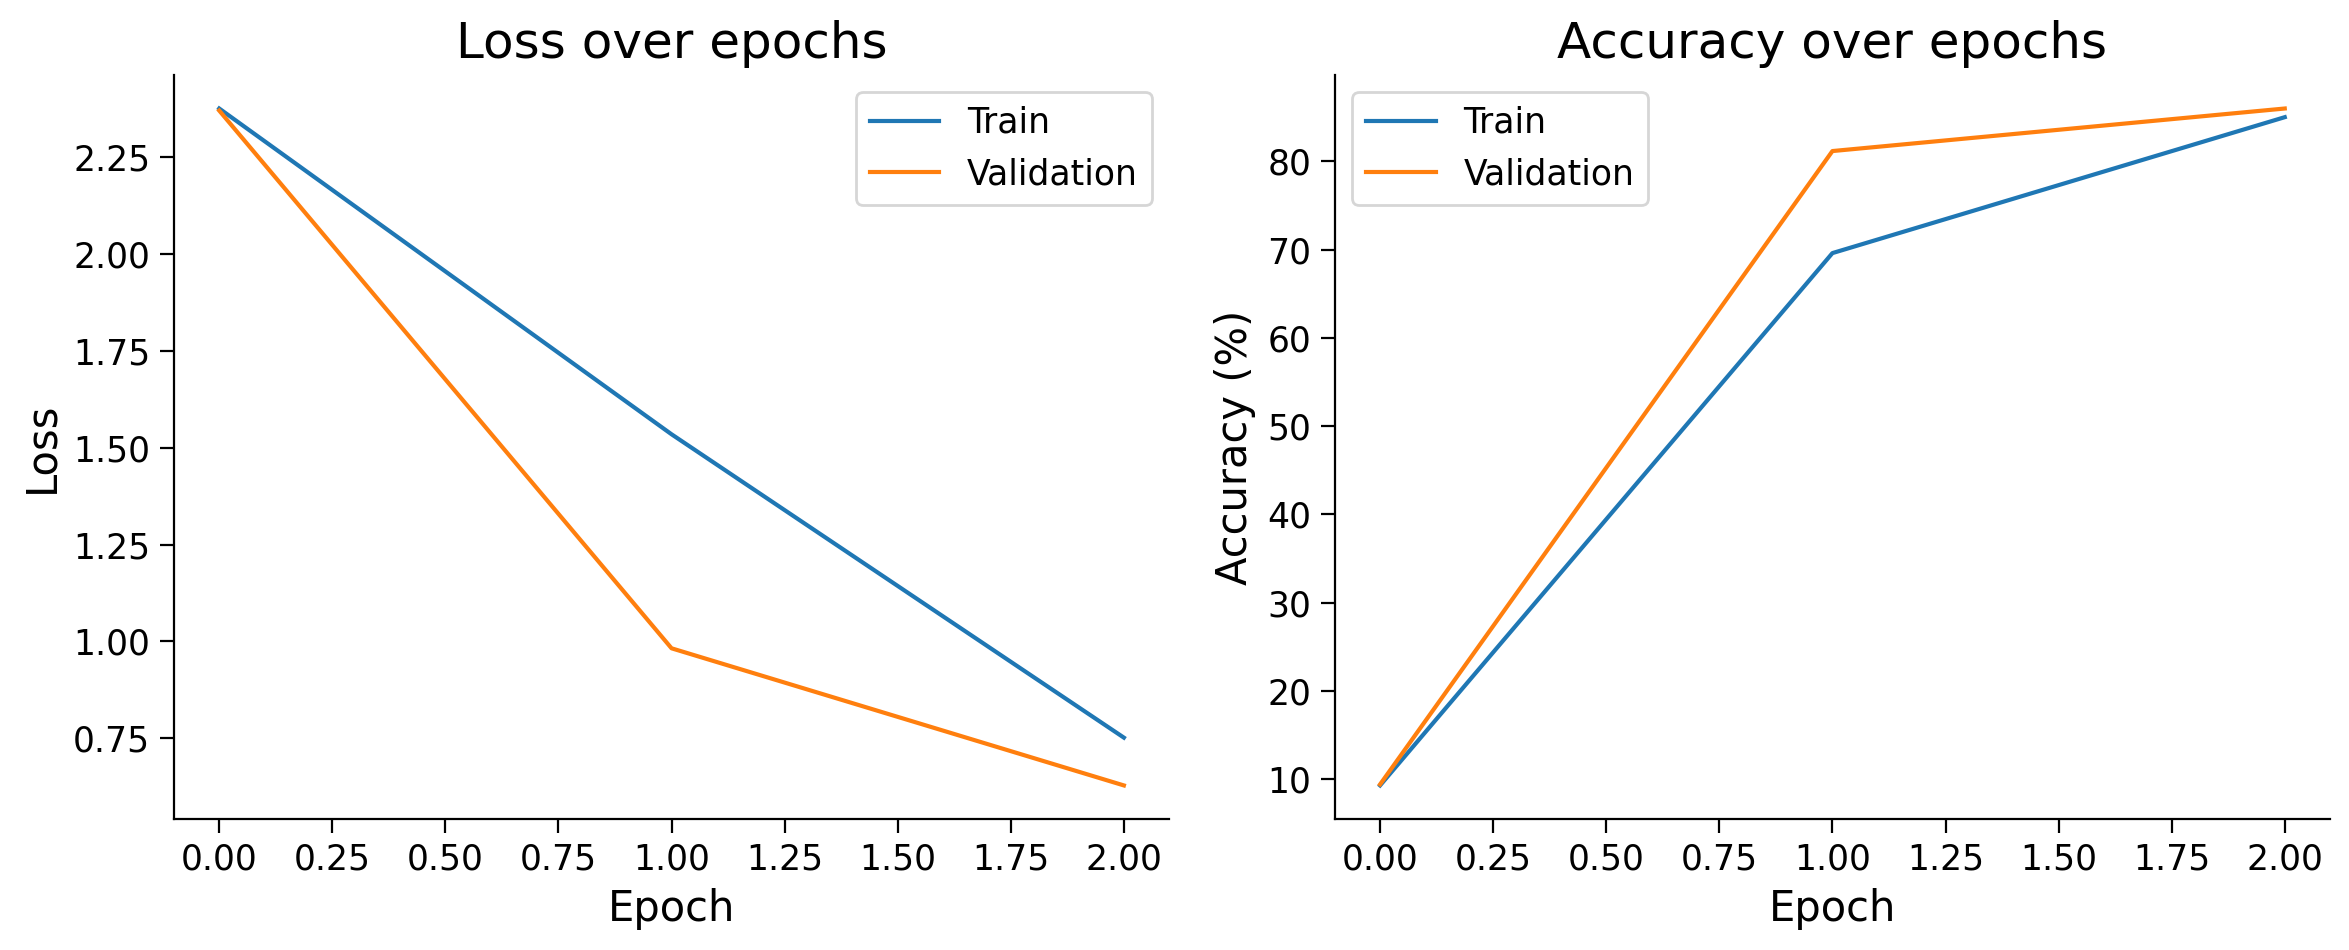

Epochs:  60%|██████    | 3/5 [00:38<00:22, 11.45s/it]

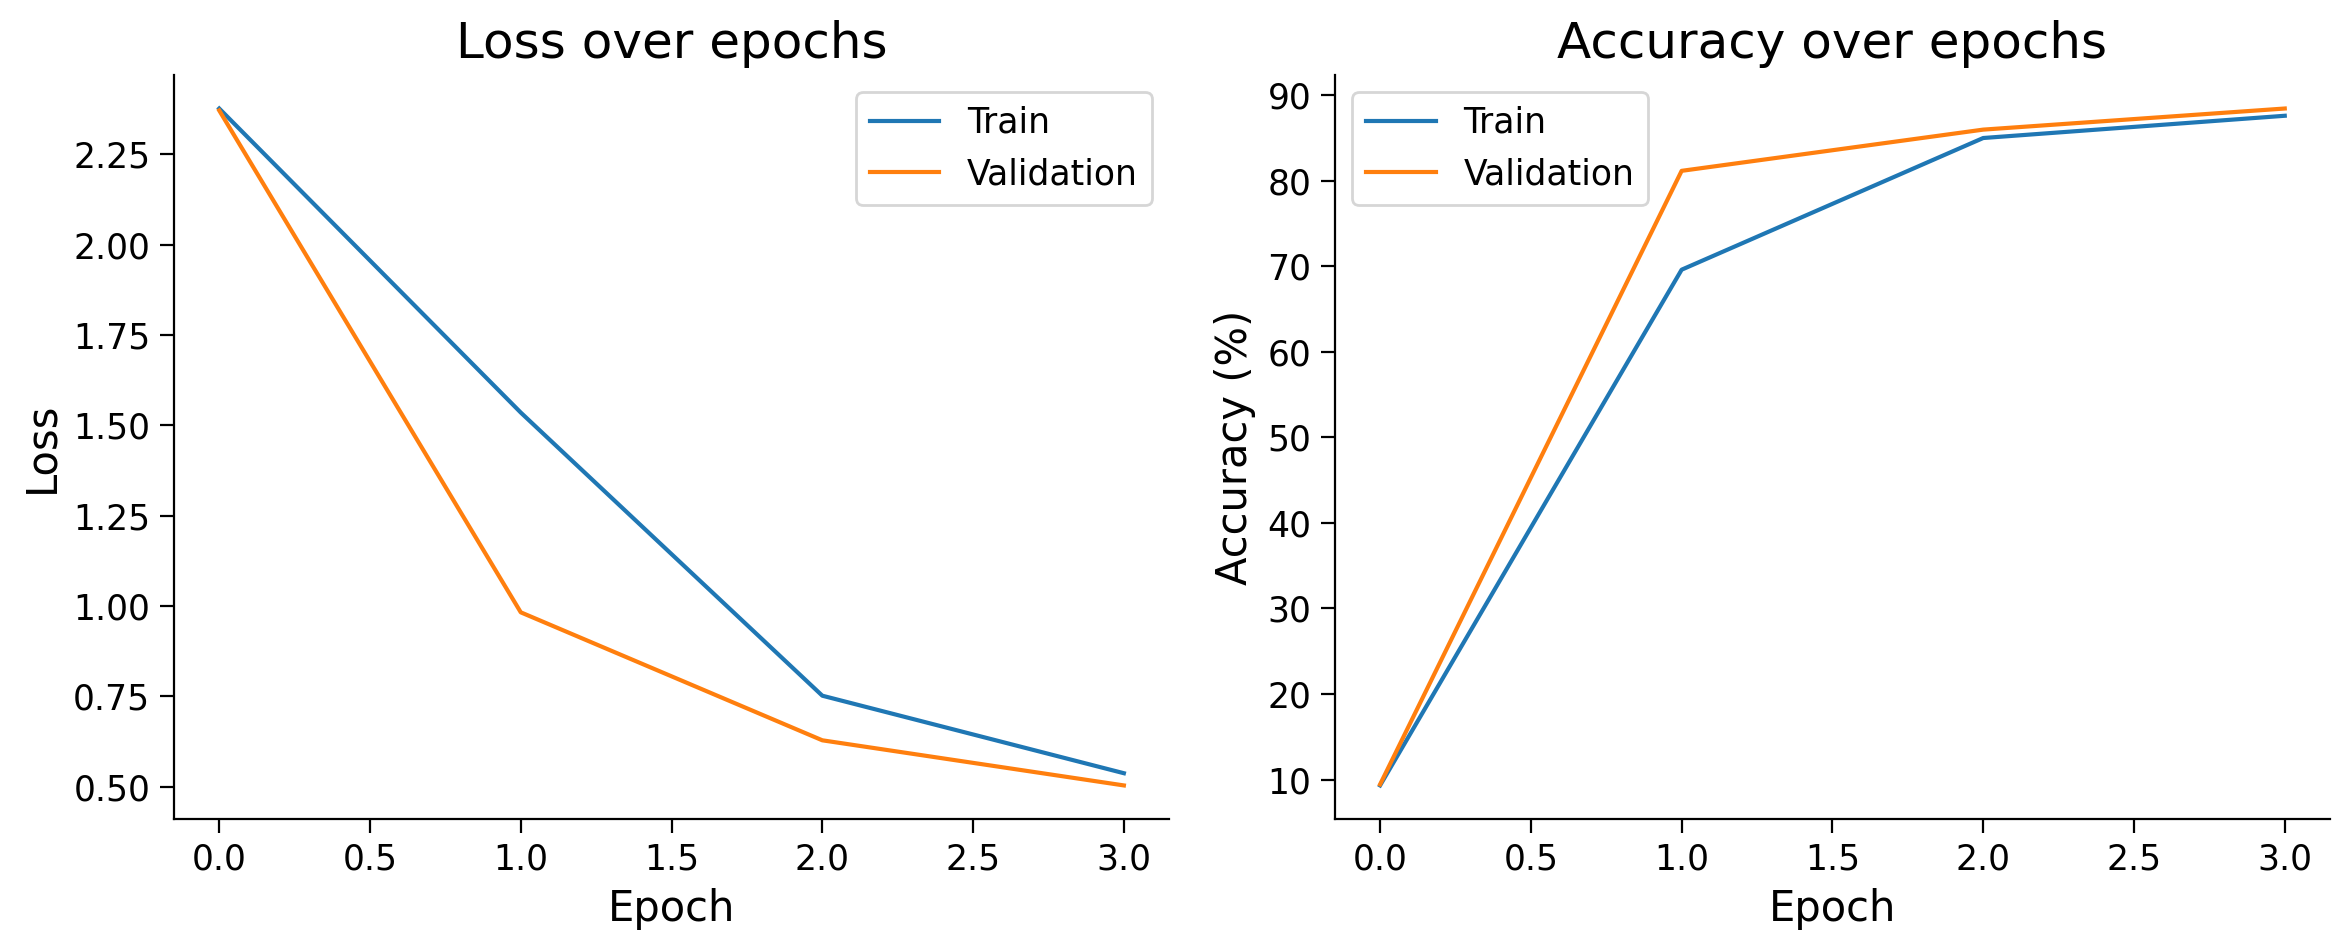

Epochs:  80%|████████  | 4/5 [00:47<00:10, 10.50s/it]

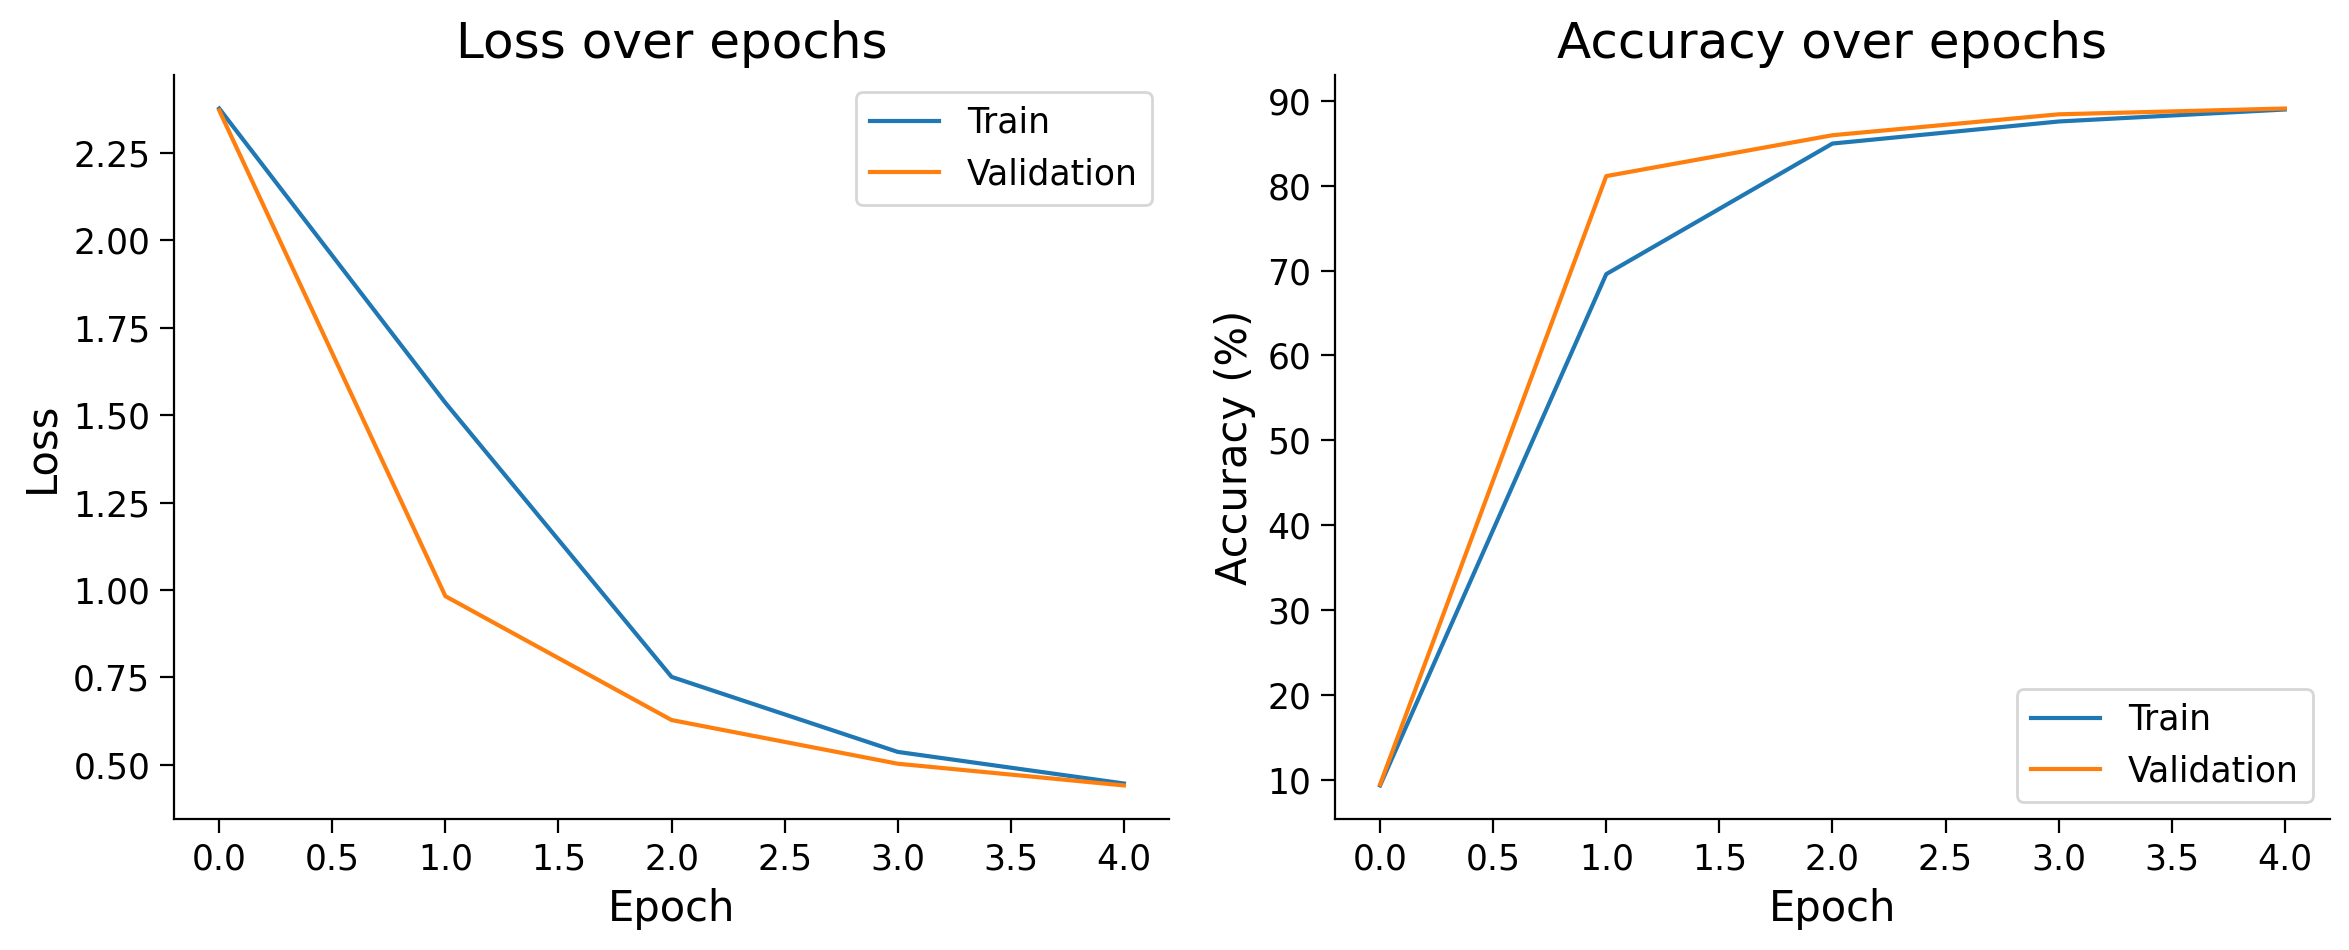

Epochs: 100%|██████████| 5/5 [01:01<00:00, 12.31s/it]


In [12]:
# @title Run Training
NUM_EPOCHS = 5

MLP_results_dict = train_model(
    MLP,
    train_loader,
    valid_loader,
    optimizer=backprop_optimizer,
    num_epochs=NUM_EPOCHS
    )

Results by class (train set):
  Class 0: 96.08% (2282/2375)
  Class 1: 96.33% (2601/2700)
  Class 2: 84.99% (2021/2378)
  Class 3: 85.25% (2098/2461)
  Class 4: 90.92% (2114/2325)
  Class 5: 82.21% (1775/2159)
  Class 6: 93.31% (2219/2378)
  Class 7: 90.96% (2285/2512)
  Class 8: 83.00% (1933/2329)
  Class 9: 85.23% (2032/2384)
Results by class (valid set):
  Class 0: 96.18% (529/550)
  Class 1: 96.72% (648/670)
  Class 2: 85.45% (505/591)
  Class 3: 86.62% (518/598)
  Class 4: 89.67% (521/581)
  Class 5: 80.54% (447/555)
  Class 6: 94.63% (581/614)
  Class 7: 89.31% (560/627)
  Class 8: 83.58% (499/597)
  Class 9: 87.34% (538/616)
Test accuracy: 89.74%


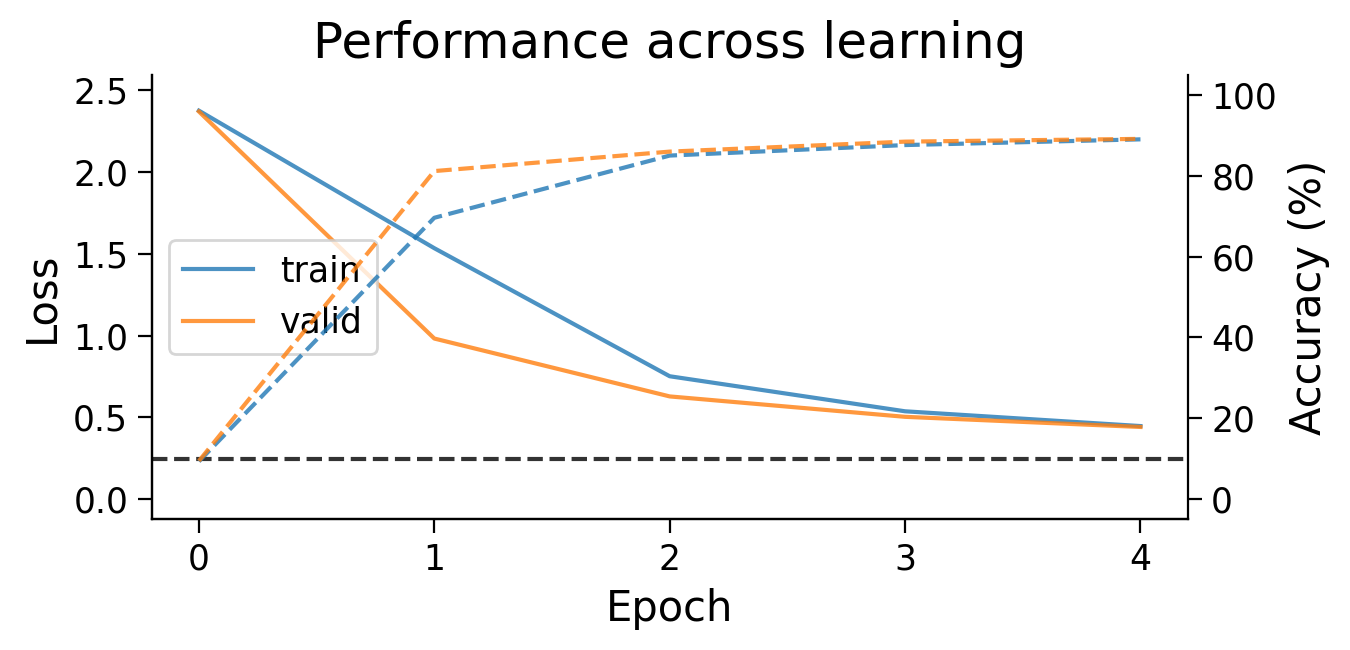

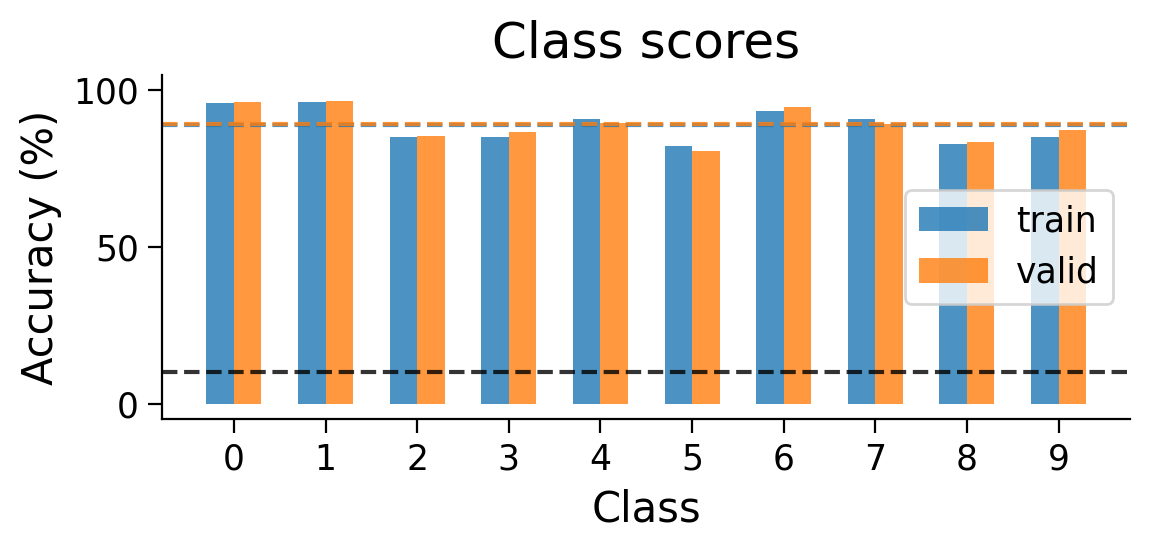

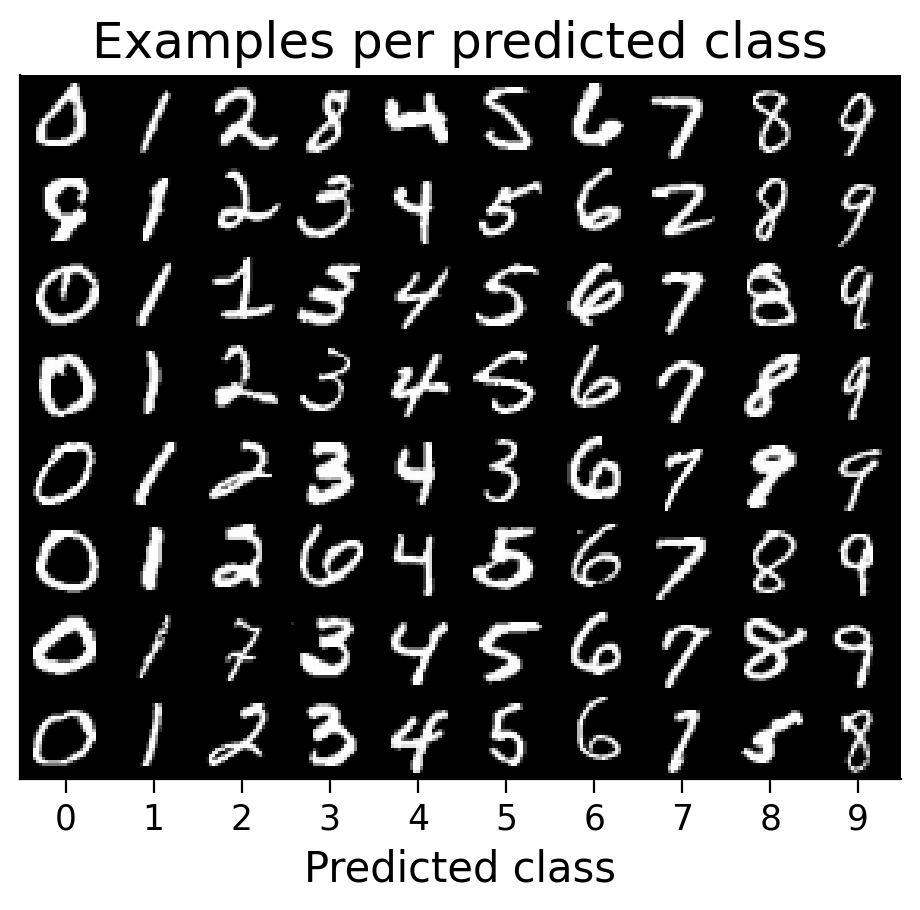

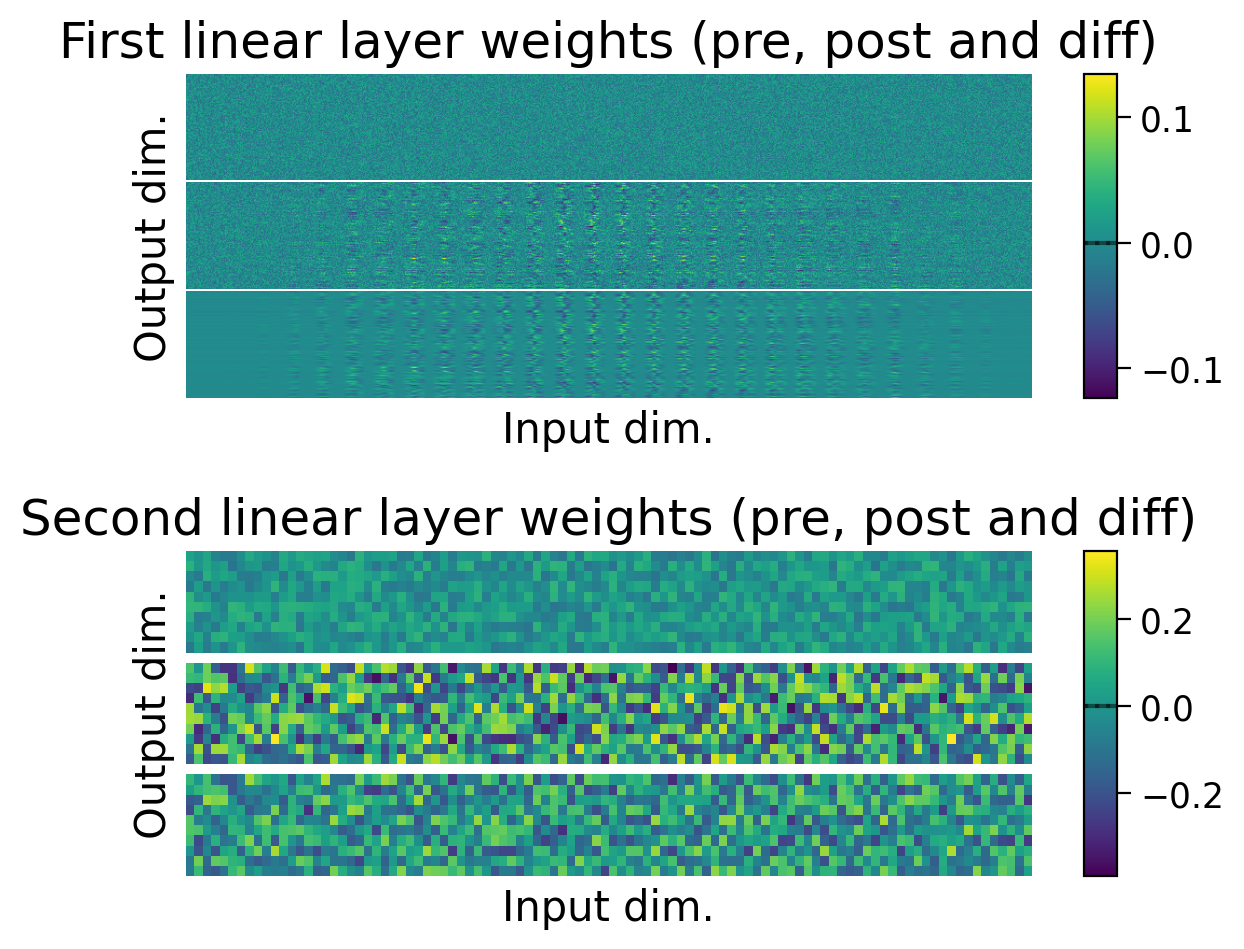

In [13]:
# @title Results

plot_results(MLP_results_dict, num_classes=10)
plot_scores_per_class(MLP_results_dict, num_classes=10)
plot_examples(valid_loader.dataset, MLP=MLP, num_classes=10)
plot_weights(MLP);

print_results_by_class(MLP_results_dict, dataset="train")
print_results_by_class(MLP_results_dict, dataset="valid")
_ = test_model(MLP, test_loader)

len(imgs_o)=10
features gathered for: ['lin1', 'lin2']


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


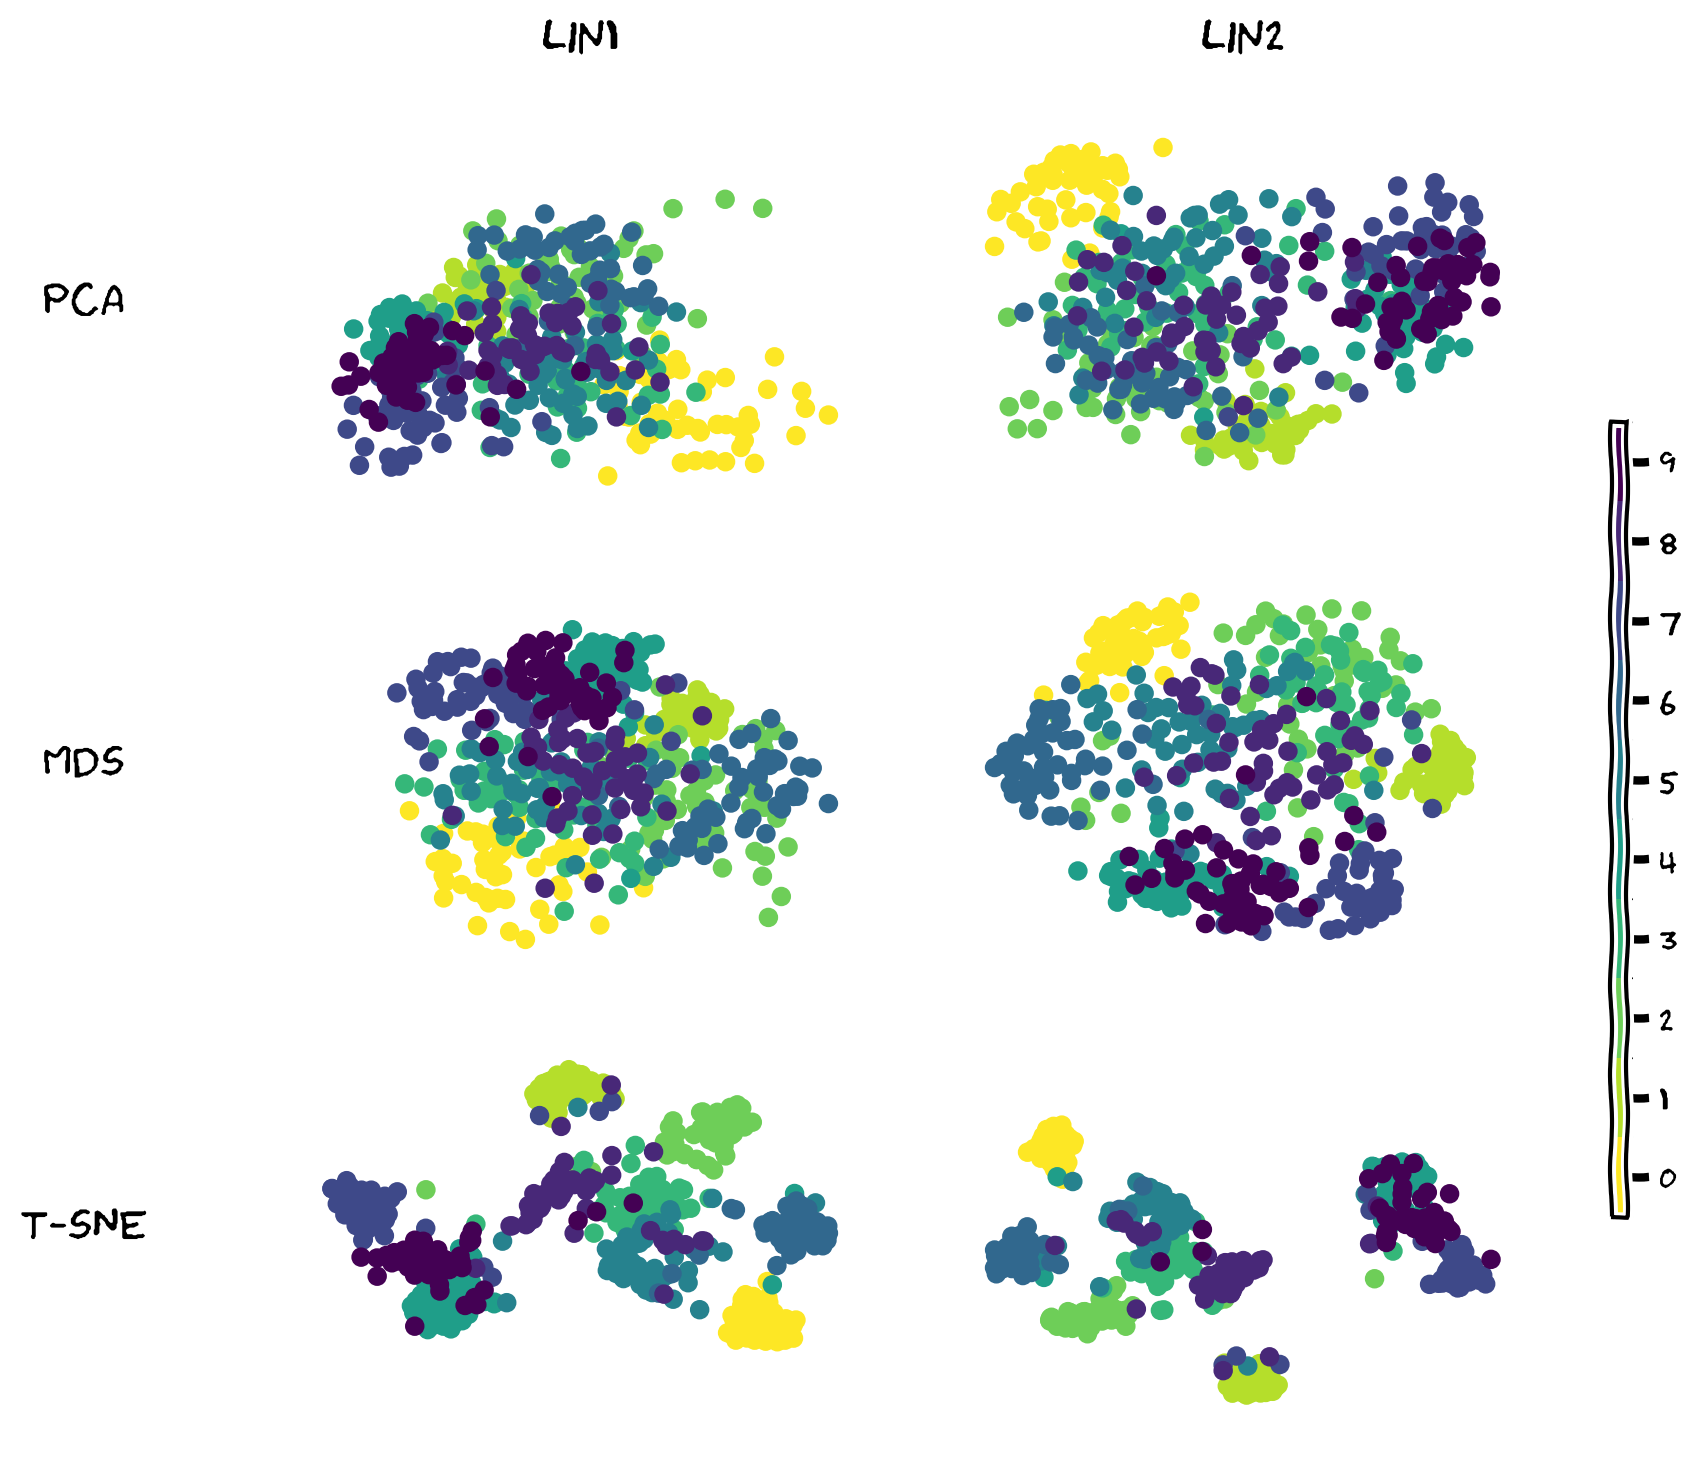

In [14]:
# @title Sequential image representation clustering

return_layers = ['lin1', 'lin2']
imgs, labels = sample_images(test_loader, n=50) #grab 50 samples from the each category

model_features = extract_features(MLP, imgs.to('cuda'), return_layers)
print('features gathered for:', list(model_features.keys()))
plot_dim_reduction(model_features, labels, transformer_funcs =['PCA', 'MDS', 't-SNE'])

In [15]:
# @title Test on Adversarial Data

# Sample images and their corresponding targets
print("Sampling images from the test loader...")
imgs, targets = sample_images(test_loader, n=20, plot=False)

# # Print the shapes of the sampled images and targets for verification
# print(f'Image Tensor Shape: {imgs.shape}')
# print(f'Target Tensor Shape: {targets.shape}')

# Generate adversarial images from the sampled images
print("Generating adversarial images...")
adv_imgs = generate_adversarial(MLP, imgs, targets, epsilon=0.2)
print("Adversarial images generated.")

# Test the model on the adversarial images
print("Testing the model on adversarial images...")
test_adversarial(MLP, adv_imgs, targets)


Sampling images from the test loader...
len(imgs_o)=10
Generating adversarial images...
imgs.shape=torch.Size([200, 1, 28, 28])
Adversarial images generated.
Testing the model on adversarial images...
adversarial test accuracy = 9 / 200 = 0.045


### Introduce Feedback Control to MLP for Hebbian Learning Rules

In [16]:
# @title FB_Function

# class FB_Function(torch.autograd.Function):
#   """
#   Gradient computing function class for Hebbian learning.
#   """

#   staticmethod
#   def forward(context, input, weight, bias=None, nonlinearity=None, target=None):
#     """
#     Forward pass method for the layer. Computes the output of the layer and
#     stores variables needed for the backward pass.

#     Arguments:
#     - context (torch context): context in which variables can be stored for
#       the backward pass.
#     - input (torch tensor): input to the layer.
#     - weight (torch tensor): layer weights.
#     - bias (torch tensor, optional): layer biases.
#     - nonlinearity (torch functional, optional): nonlinearity for the layer.
#     - target (torch tensor, optional): layer target, if applicable.

#     Returns:
#     - output (torch tensor): layer output.
#     """

#     # compute the output for the layer (linear layer with non-linearity)
#     output = input.mm(weight.t())
#     if bias is not None:
#       output += bias.unsqueeze(0).expand_as(output)
#     if nonlinearity is not None:
#       output = nonlinearity(output)

#     # calculate the output to use for the backward pass
#     output_for_update = output if target is None else target

#     # store variables in the context for the backward pass
#     context.save_for_backward(input, weight, bias, output_for_update)

#     return output

#   staticmetho
#   def backward(context, grad_output=None):
#     """
#     Backward pass method for the layer. Computes and returns the gradients for
#     all variables passed to forward (returning None if not applicable).

#     Arguments:
#     - context (torch context): context in which variables can be stored for
#       the backward pass.
#     - input (torch tensor): input to the layer.
#     - weight (torch tensor): layer weights.
#     - bias (torch tensor, optional): layer biases.
#     - nonlinearity (torch functional, optional): nonlinearity for the layer.
#     - target (torch tensor, optional): layer target, if applicable.

#     Returns:
#     - grad_input (None): gradients for the input (None, since gradients are not
#       backpropagated in Hebbian learning).
#     - grad_weight (torch tensor): gradients for the weights.
#     - grad_bias (torch tensor or None): gradients for the biases, if they aren't
#       None.
#     - grad_nonlinearity (None): gradients for the nonlinearity (None, since
#       gradients do not apply to the non-linearities).
#     - grad_target (None): gradients for the targets (None, since
#       gradients do not apply to the targets).
#     """

#     input, weight, bias, output_for_update = context.saved_tensors
#     grad_input = None
#     grad_weight = None
#     grad_bias = None
#     grad_nonlinearity = None
#     grad_target = None

#     input_needs_grad = context.needs_input_grad[0]
#     if input_needs_grad:
#       pass

#     weight_needs_grad = context.needs_input_grad[1]
#     if weight_needs_grad:
#       grad_weight = output_for_update.t().mm(input)
#       grad_weight = grad_weight / len(input) # average across batch

#       # center around 0
#       grad_weight = grad_weight - grad_weight.mean(axis=0) # center around 0

#       ## or apply Oja's rule (not compatible with clamping outputs to the targets!)
#       # oja_subtract = output_for_update.pow(2).mm(grad_weight).mean(axis=0)
#       # grad_weight = grad_weight - oja_subtract

#       # take the negative, as the gradient will be subtracted
#       grad_weight = -grad_weight

#     if bias is not None:
#       bias_needs_grad = context.needs_input_grad[2]
#       if bias_needs_grad:
#         grad_bias = output_for_update.mean(axis=0) # average across batch

#         # center around 0
#         grad_bias = grad_bias - grad_bias.mean()

#         ## or apply an adaptation of Oja's rule for biases
#         ## (not compatible with clamping outputs to the targets!)
#         # oja_subtract = (output_for_update.pow(2) * bias).mean(axis=0)
#         # grad_bias = grad_bias - oja_subtract

#         # take the negative, as the gradient will be subtracted
#         grad_bias = -grad_bias

#     return grad_input, grad_weight, grad_bias, grad_nonlinearity, grad_target


In [25]:
# @title FBMultiLayerPerceptron Class
class FBMultiLayerPerceptron(MultiLayerPerceptron):
  """
  Hebbian multilayer perceptron with one hidden layer.
  """

  def __init__(self, clamp_output=True, epsilon=0.3, **kwargs):
    """
    Initializes a Hebbian multilayer perceptron object

    Arguments:
    - clamp_output (bool, optional): if True, outputs are clamped to targets,
      if available, when computing weight updates.
    """

    self.clamp_output = clamp_output
    self.epsilon = epsilon
    super().__init__(**kwargs)


  def forward(self, X, y=None):
    """
    Runs a forward pass through the network.

    Arguments:
    - X (torch.Tensor): Batch of input images.
    - y (torch.Tensor, optional): Batch of targets, stored for the backward
      pass to compute the gradients for the last layer.

    Returns:
    - y_pred (torch.Tensor): Predicted targets.
    """

    torch.autograd.set_detect_anomaly(True)
    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
    h.requires_grad_(True)
    h.retain_grad()

    y_pred = self.softmax(self.lin2(h))
    y_pred.requires_grad_(True)
    y_pred.retain_grad()


    if y is not None:
      #### COMPUTE CONTROL SIGNALS FOR EACH LAYER
      criterion = torch.nn.NLLLoss()
      loss = criterion(torch.log(y_pred), y)
      loss.backward() # make sure this doesn't do anything weird

      # print('\n')
      # for param in self.list_parameters():
      #   print(param)
      #   print(self.gather_gradient_dict()[param].shape)

      # J = torch.autograd.function.jacobian()

      # print(f'{h.shape=}')
      # print(f'{y_pred.shape=}')

      epsilon = self.epsilon
      hgrad = h.grad
      # print(f'{h.grad.shape=}')
      # ygrad = np.sum(self.gather_gradient_dict()[self.list_parameters()[1]], axis=1)
      # B = torch.random.normal(0, 1, y_pred.size) #not right have to fix
      control_h = -epsilon * h.grad.clone()
      control_y = -epsilon * y_pred.grad.clone()
      self.zero_grad()

      ############################################

      h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
      h = h + control_h
      y_pred = self.softmax(self.lin2(h))
      y_pred = y_pred + control_y

    return y_pred

In [29]:
# @title Initialize FBMultiLayerPerceptron
# @markdown Set the model parameters:
NUM_HIDDEN = 100  # @param {type:"integer"}
NUM_OUTPUTS = 10  # @param {type:"integer"}
ACTIVATION_TYPE = "sigmoid"  # @param ["sigmoid", "tanh", "relu", "linear"]
CLAMP_OUTPUT = False  # @param {type:"boolean"}
USE_BIAS = False  # @param {type:"boolean"}
EPSILON = 0.7  # @param {type:"number"}

# @markdown You can adjust the model parameters above.

# Initialize the model
FBMLP = FBMultiLayerPerceptron(
    num_hidden=NUM_HIDDEN,
    num_outputs=NUM_OUTPUTS,
    clamp_output=CLAMP_OUTPUT,
    bias=USE_BIAS,
    epsilon=EPSILON,
)

print(f"Model initialized for {DATASET} dataset")
print(f"Input size: {NUM_INPUTS}")
print(f"Hidden layer size: {NUM_HIDDEN}")
print(f"Output size: {NUM_OUTPUTS}")
print(f"Activation function: {ACTIVATION_TYPE}")
print(f"Clamp output: {CLAMP_OUTPUT}")
print(f"Use bias: {USE_BIAS}")
print(f"Epsilon: {EPSILON}")

# train_nodes, _ = get_graph_node_names(FBMLP)
# print(f"Model parameters: {train_nodes}")

# Dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Model initialized for MNIST dataset
Input size: 784
Hidden layer size: 100
Output size: 10
Activation function: sigmoid
Clamp output: False
Use bias: False
Epsilon: 0.7


In [30]:
# @title Initialize Optimizer

# @markdown This cell initializes the BasicOptimizer for our FBMLP model.

# Define the learning rate
FB_LR = 0.01  # @param {type:"number"}

# @markdown You can adjust the learning rate above. A higher learning rate may lead to faster training, but could also cause instability.

# Initialize the BasicOptimizer
FB_optimizer = BasicOptimizer(FBMLP.parameters(), lr=FB_LR)

# Print optimizer details
print(f"Optimizer: BasicOptimizer")
print(f"Learning rate: {FB_LR}")
print(f"Number of parameter groups: {len(FB_optimizer.param_groups)}")
total_params = sum(p.numel() for group in FB_optimizer.param_groups for p in group['params'])
print(f"Total parameters being optimized: {total_params}")

# Optionally, you can add a weight decay parameter
WEIGHT_DECAY = 0.0001  # @param {type:"number"}
FB_optimizer = BasicOptimizer(FBMLP.parameters(), lr=FB_LR, weight_decay=WEIGHT_DECAY)
print(f"Weight decay: {WEIGHT_DECAY}")

Optimizer: BasicOptimizer
Learning rate: 0.01
Number of parameter groups: 1
Total parameters being optimized: 79400
Weight decay: 0.0001


### Train and Test the FB MLP model



Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

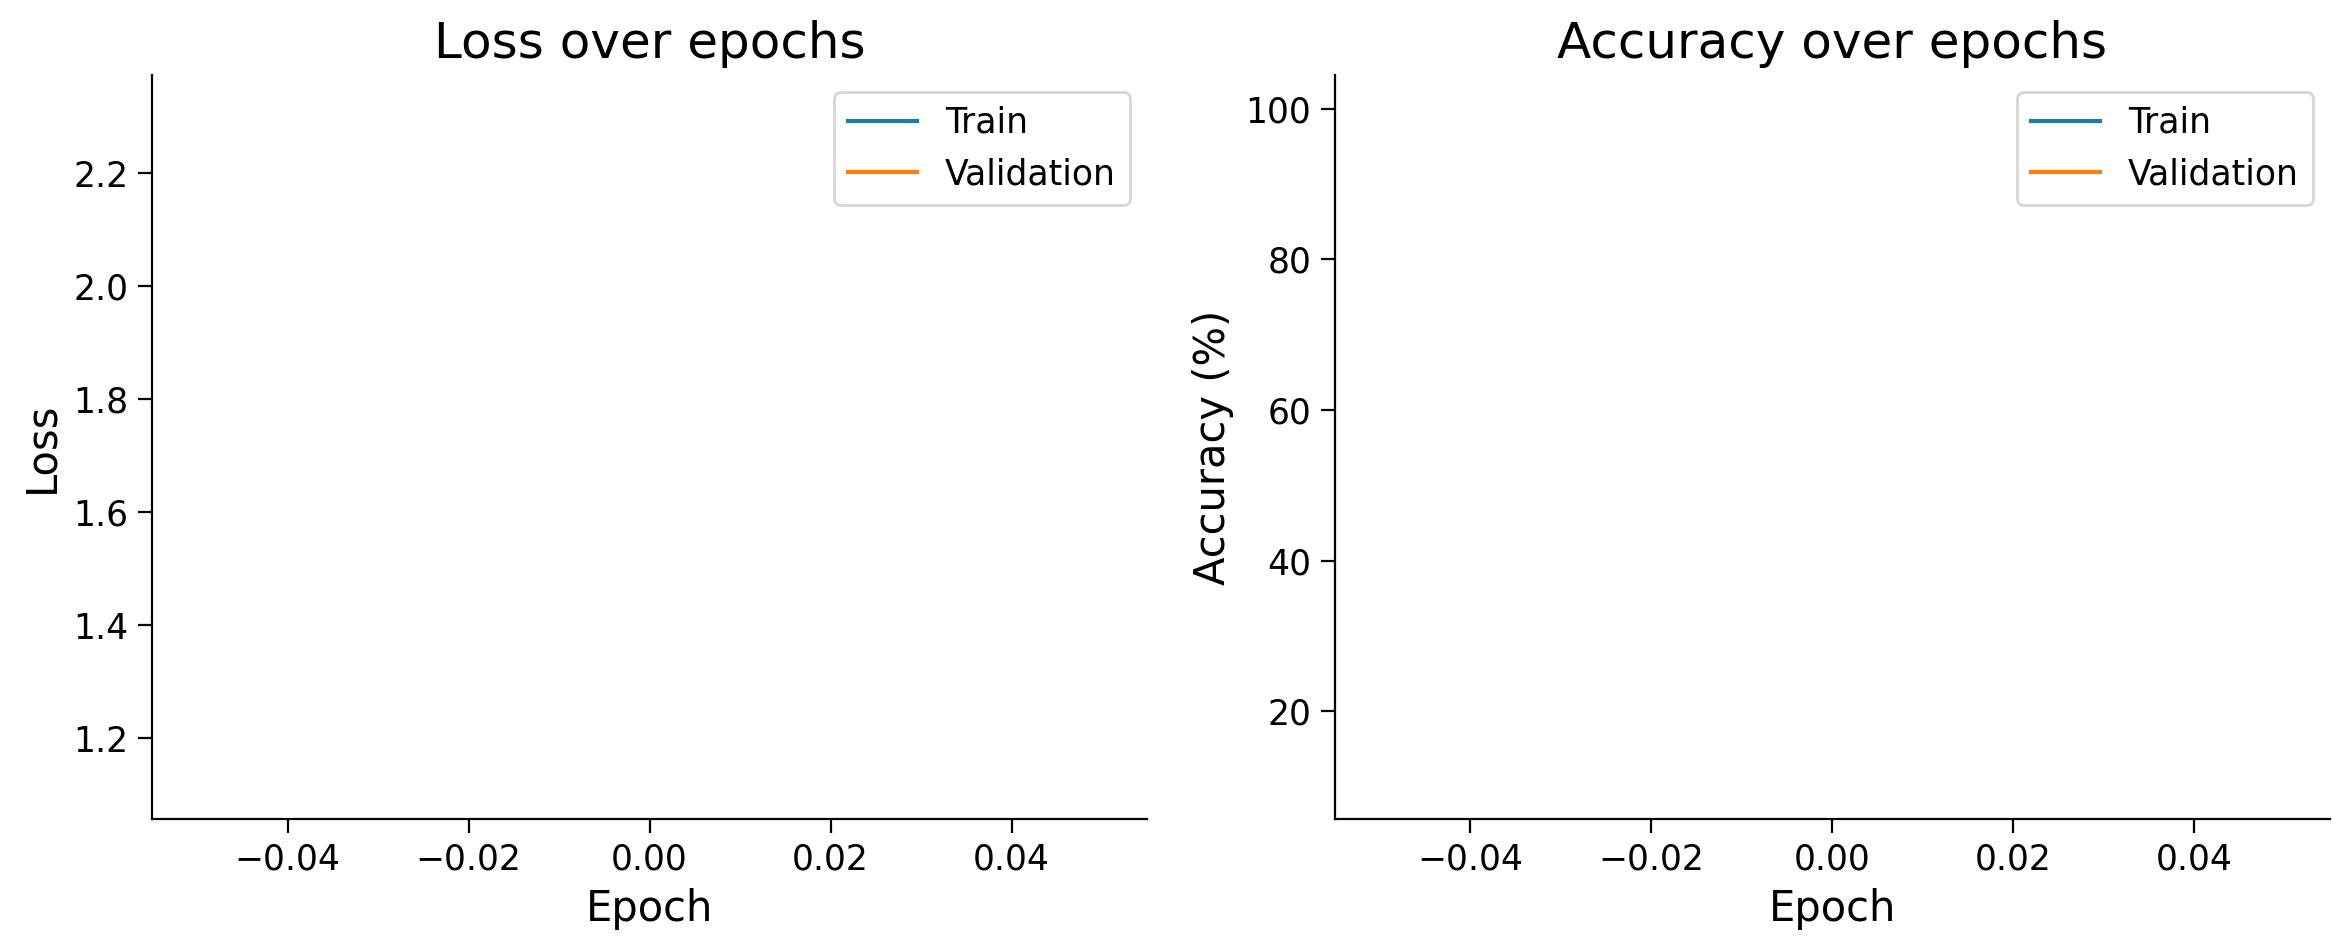

Epochs:  20%|██        | 1/5 [00:13<00:53, 13.38s/it]

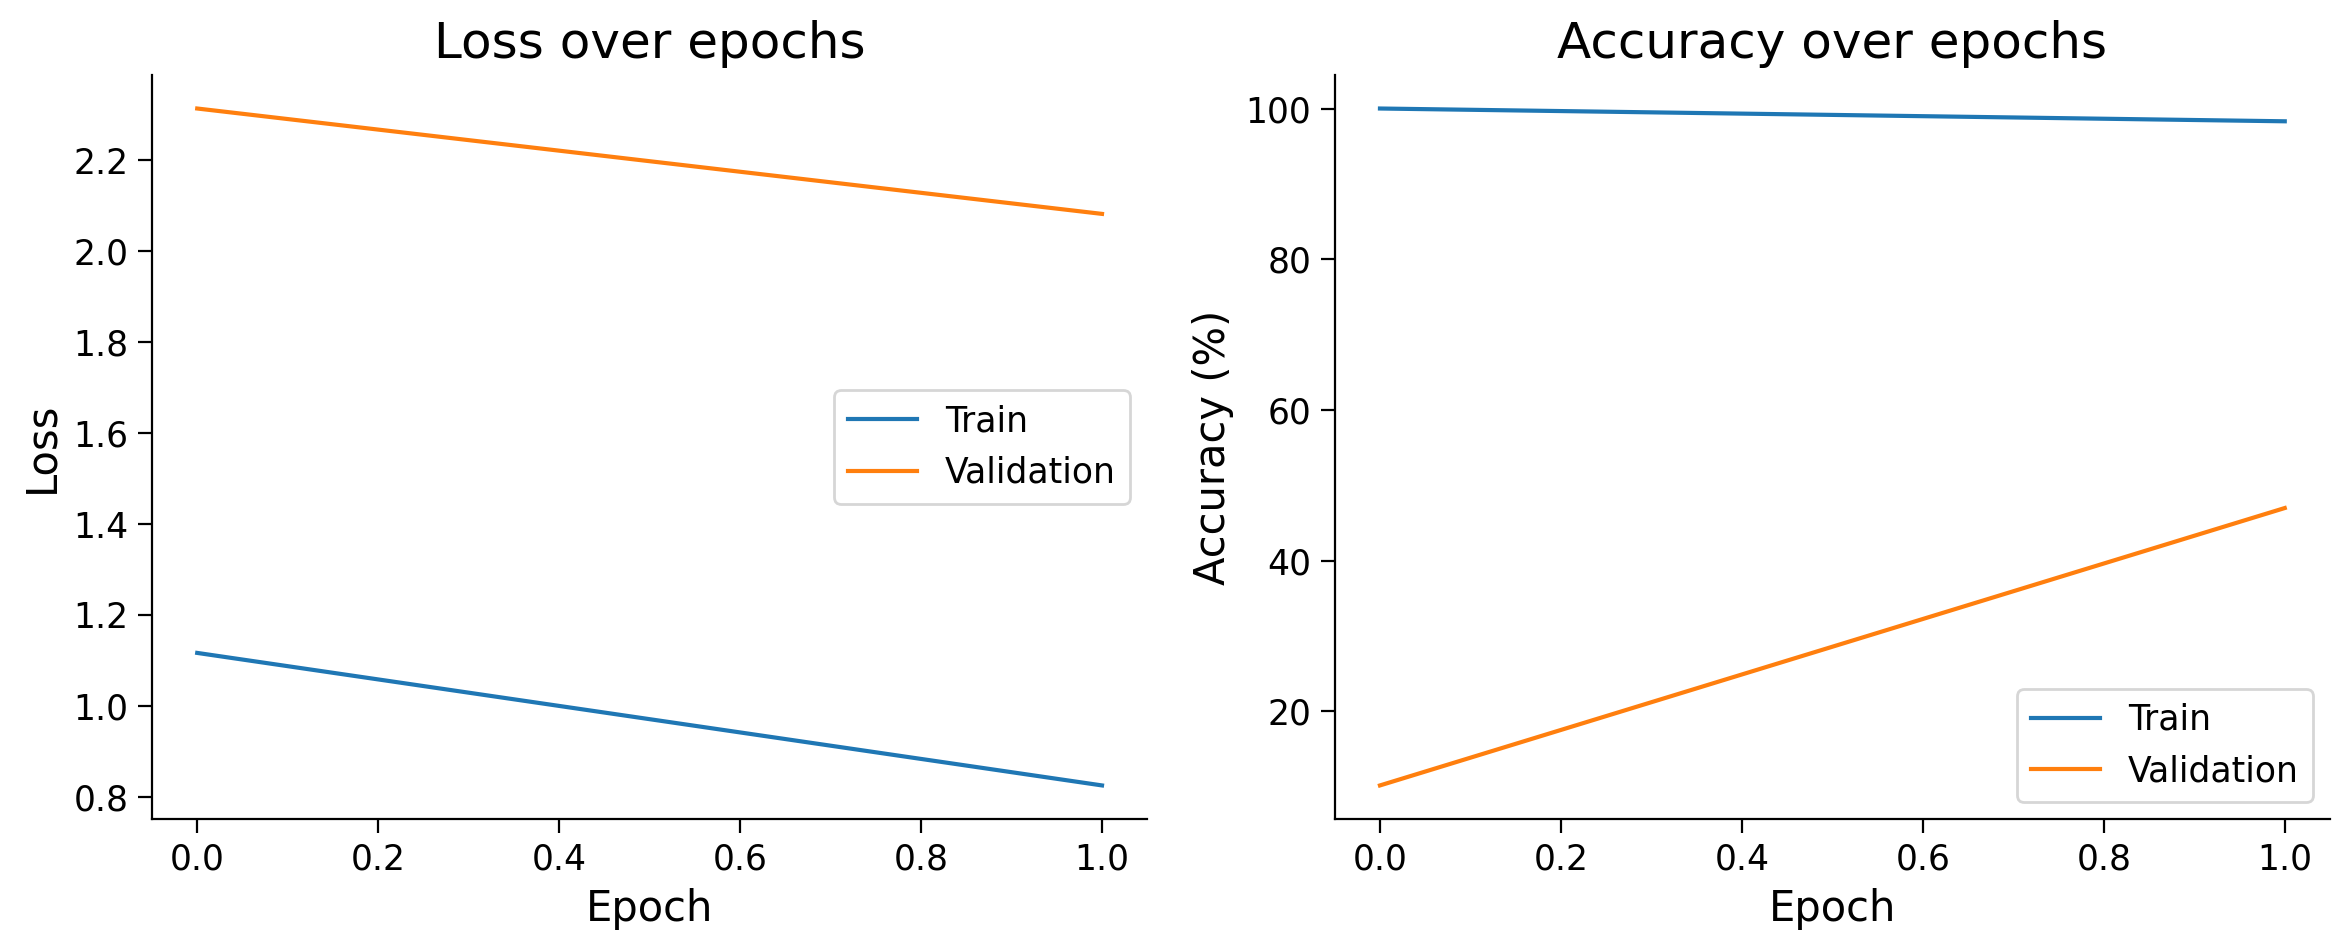

Epochs:  40%|████      | 2/5 [00:28<00:43, 14.47s/it]

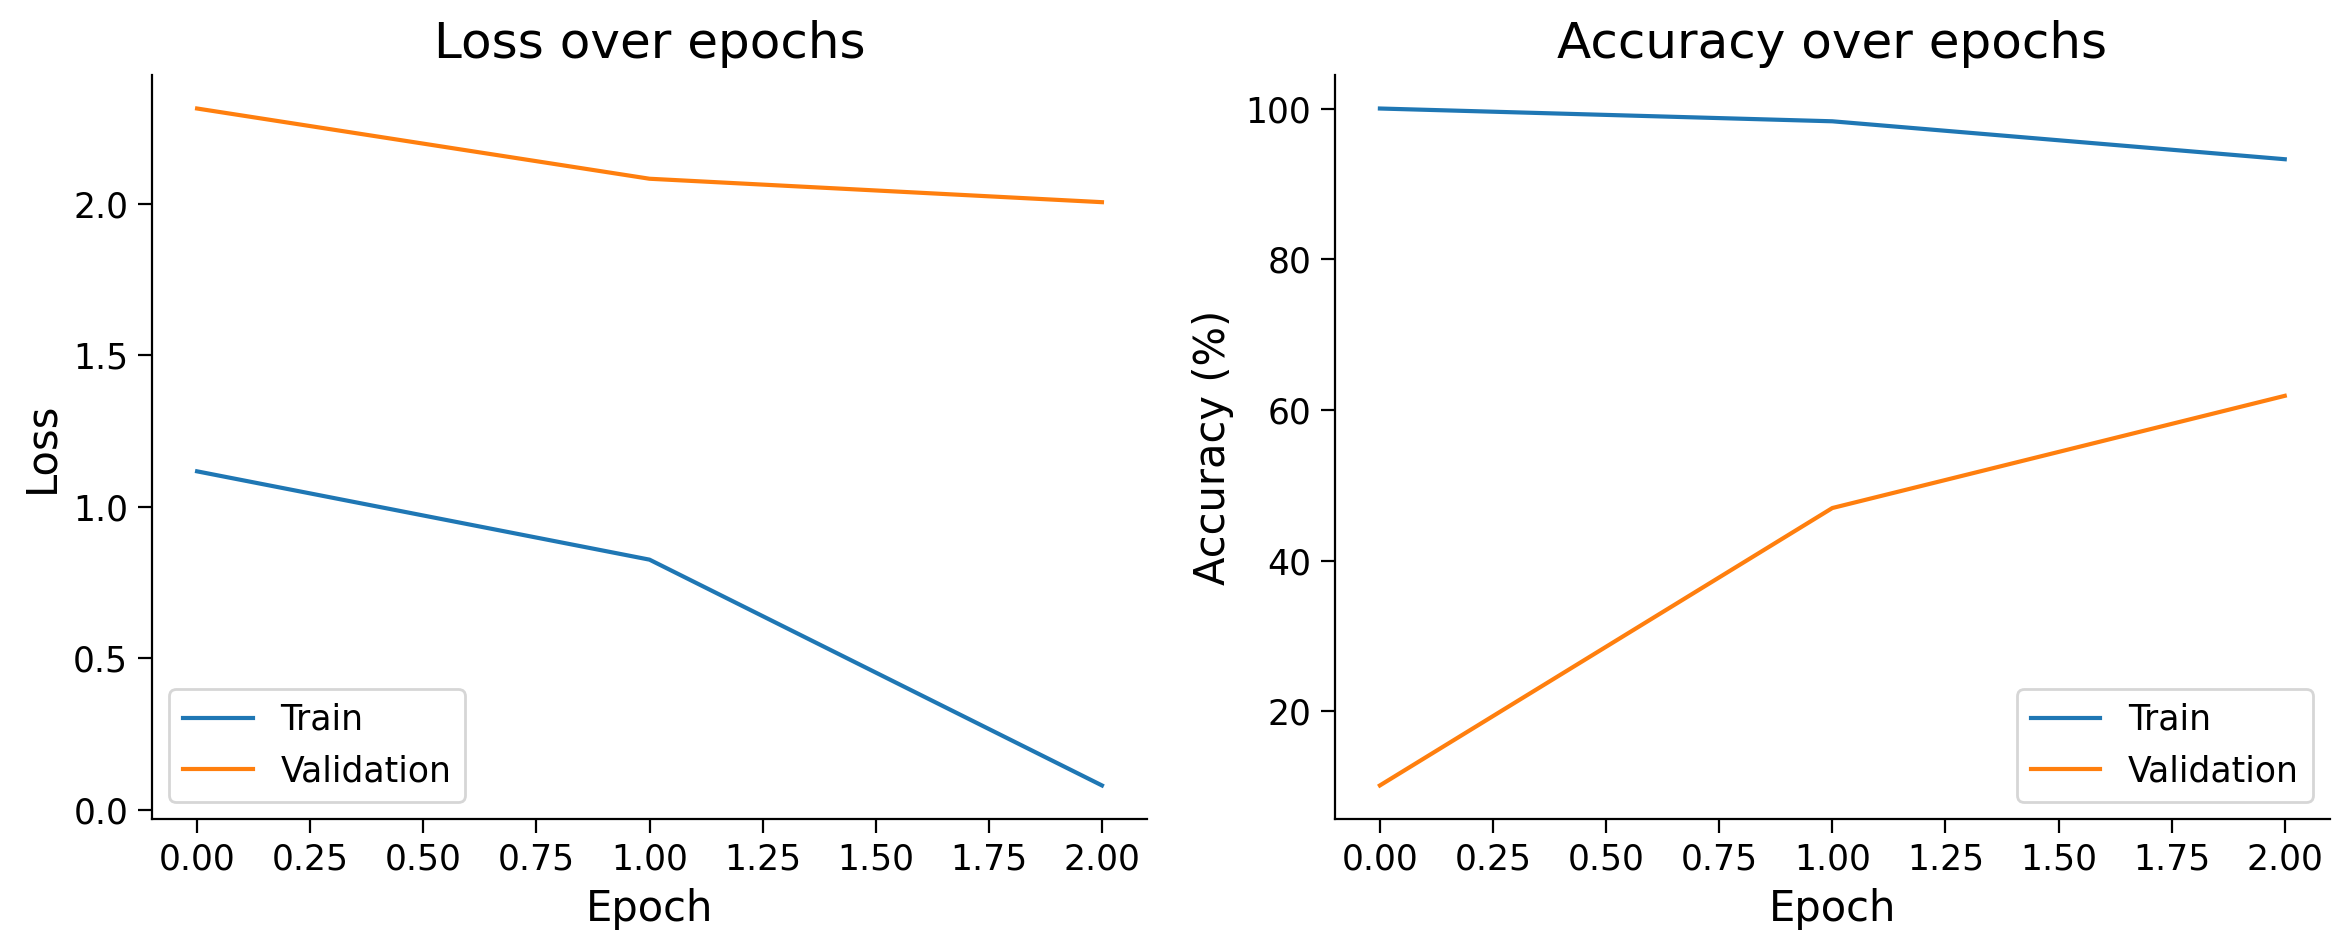

Epochs:  60%|██████    | 3/5 [00:43<00:29, 14.80s/it]

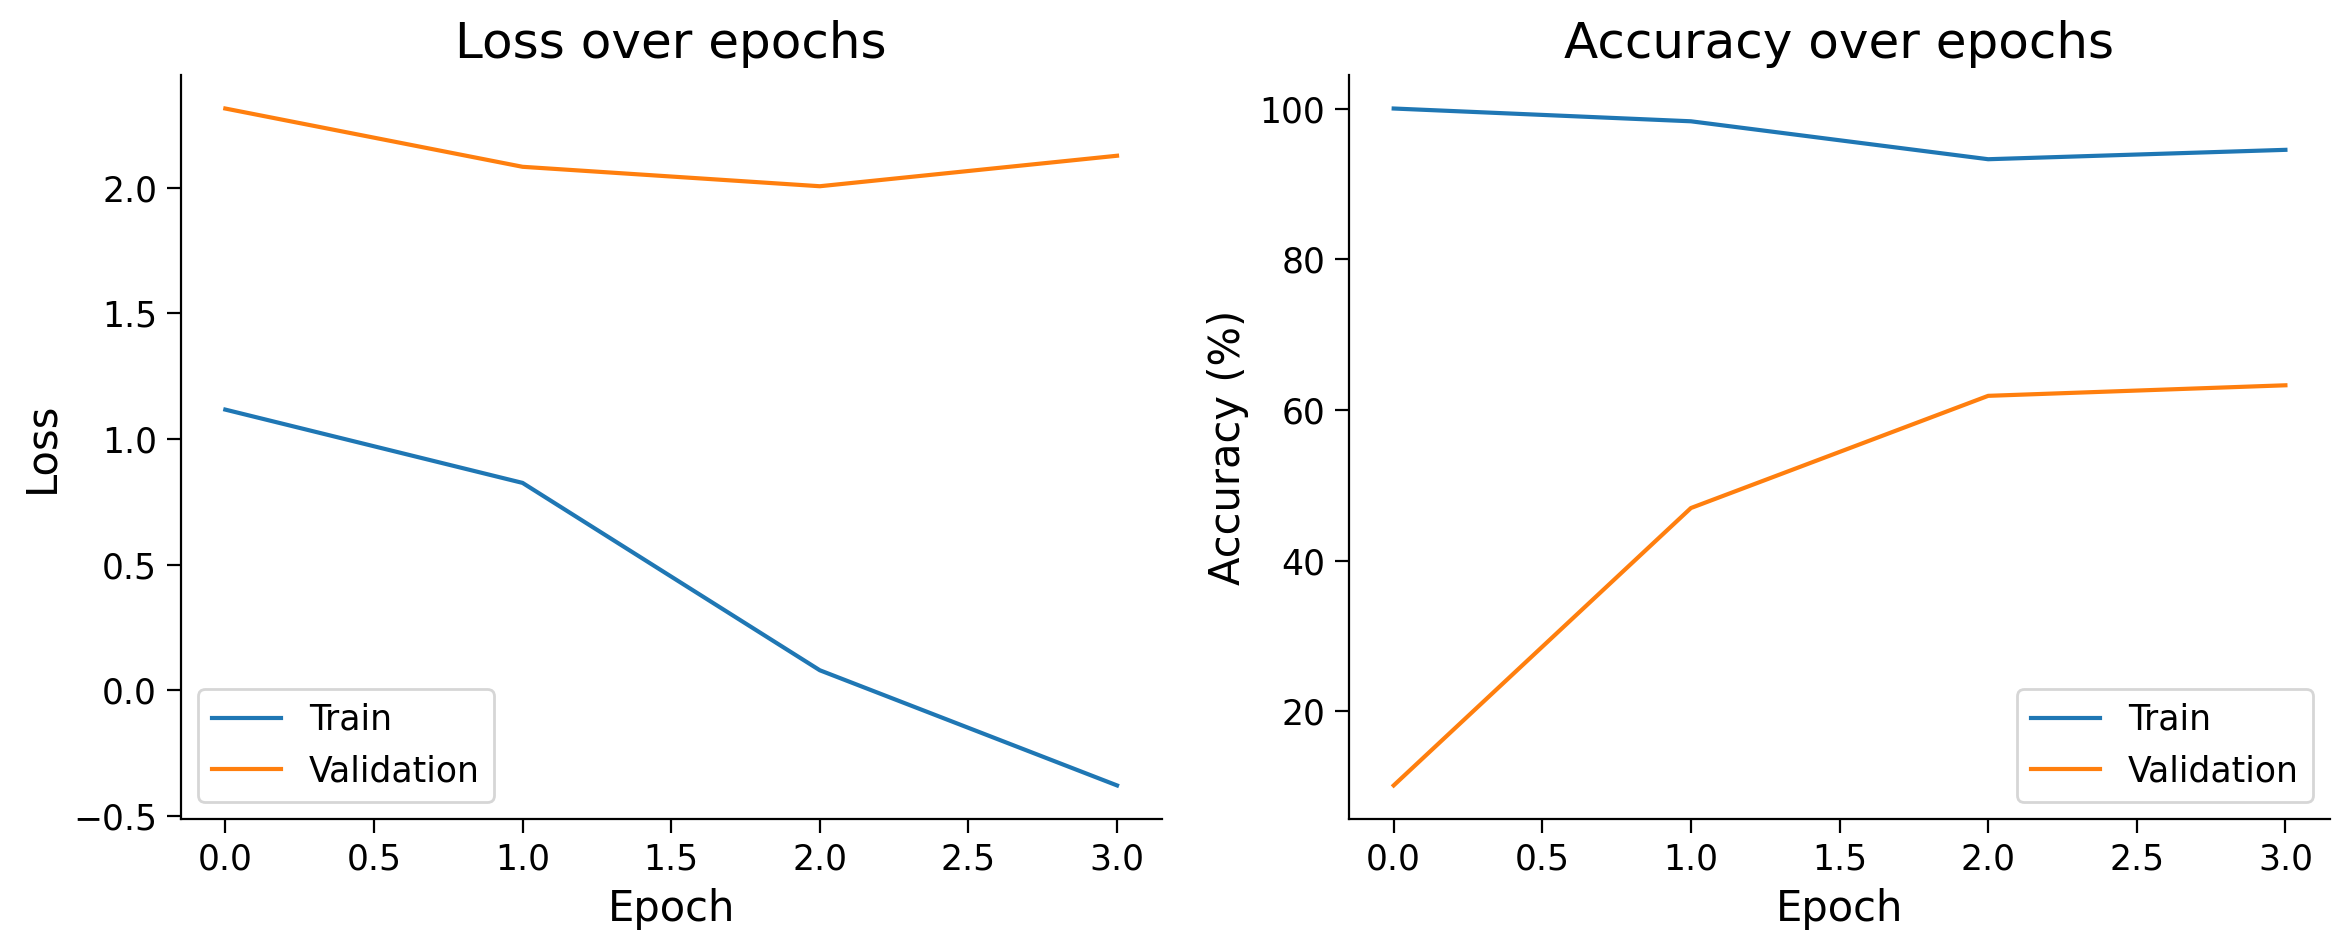

Epochs:  80%|████████  | 4/5 [00:58<00:14, 14.95s/it]

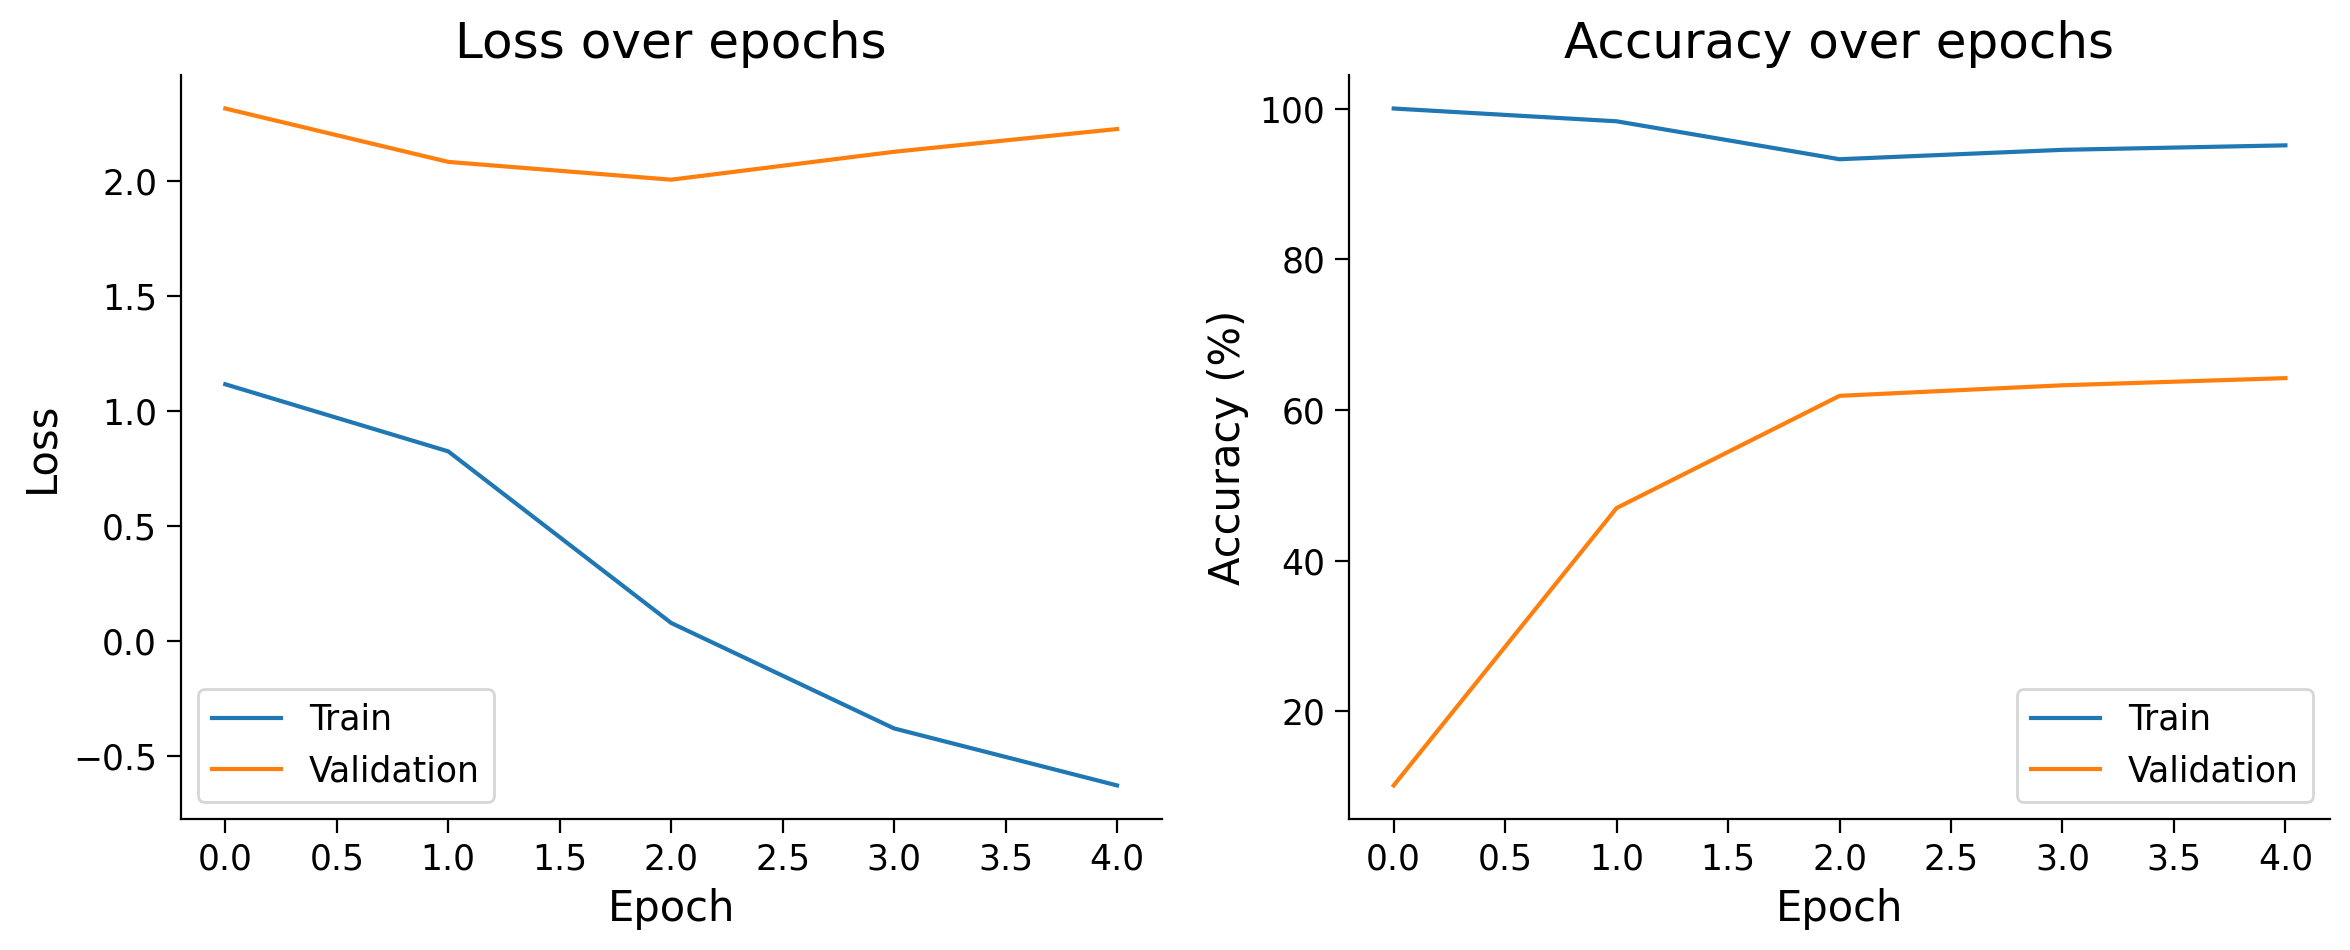

Epochs: 100%|██████████| 5/5 [01:14<00:00, 14.86s/it]


In [31]:
# @title Run Training
NUM_EPOCHS = 5

FB_results_dict = train_model(
    FBMLP,
    train_loader,
    valid_loader,
    FB_optimizer,
    num_epochs=NUM_EPOCHS
    );

Results by class (train set):
  Class 0: 97.60% (2318/2375)
  Class 1: 98.44% (2658/2700)
  Class 2: 86.80% (2064/2378)
  Class 3: 91.26% (2246/2461)
  Class 4: 100.00% (2325/2325)
  Class 5: 100.00% (2159/2159)
  Class 6: 96.01% (2283/2378)
  Class 7: 100.00% (2512/2512)
  Class 8: 84.67% (1972/2329)
  Class 9: 96.10% (2291/2384)
Results by class (valid set):
  Class 0: 95.45% (525/550)
  Class 1: 97.31% (652/670)
  Class 2: 84.26% (498/591)
  Class 3: 89.63% (536/598)
  Class 4: 0.00% (0/581)
  Class 5: 0.00% (0/555)
  Class 6: 94.14% (578/614)
  Class 7: 0.00% (0/627)
  Class 8: 82.24% (491/597)
  Class 9: 93.02% (573/616)
Test accuracy: 65.24%


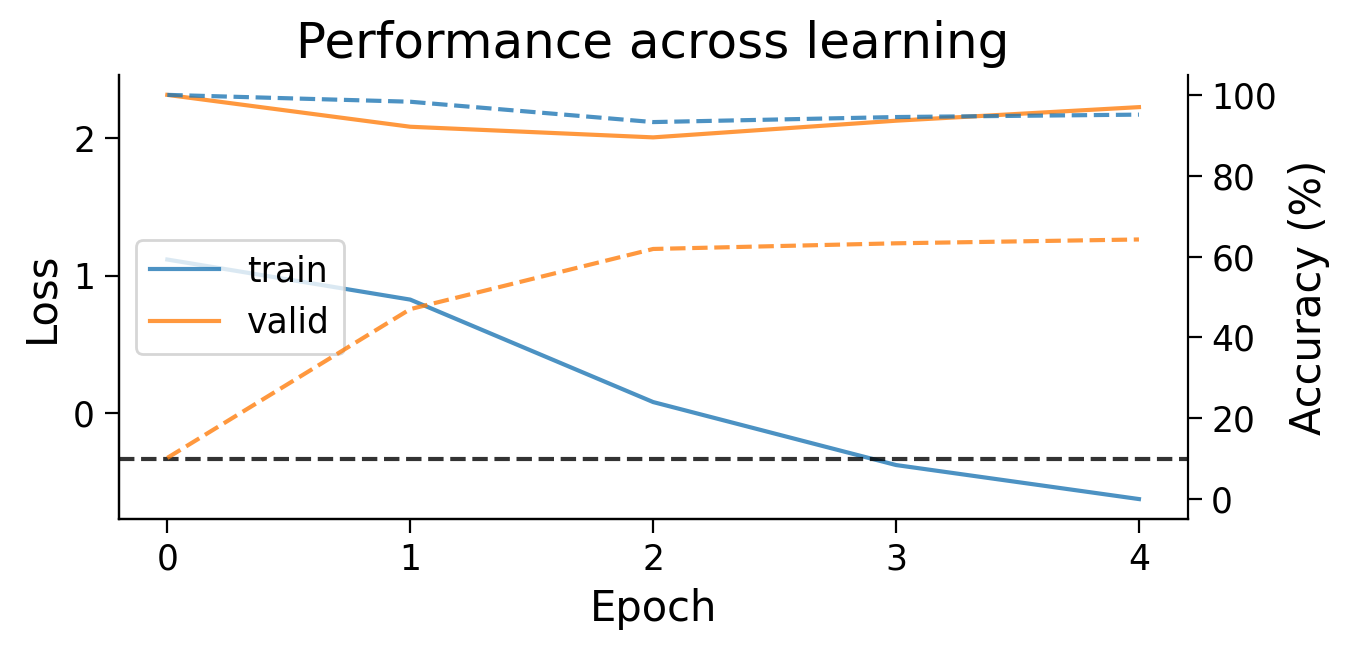

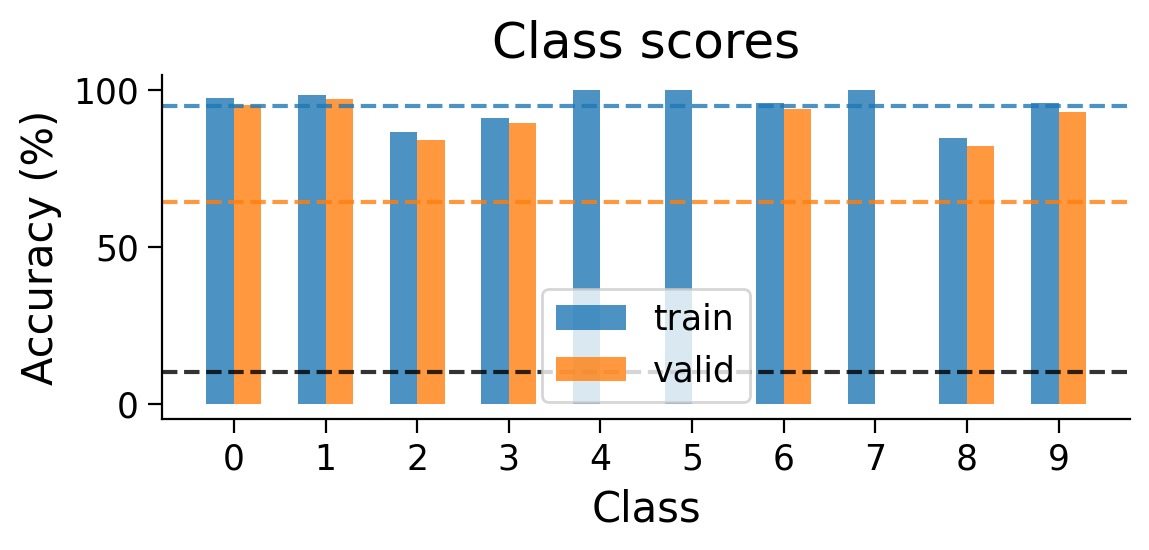

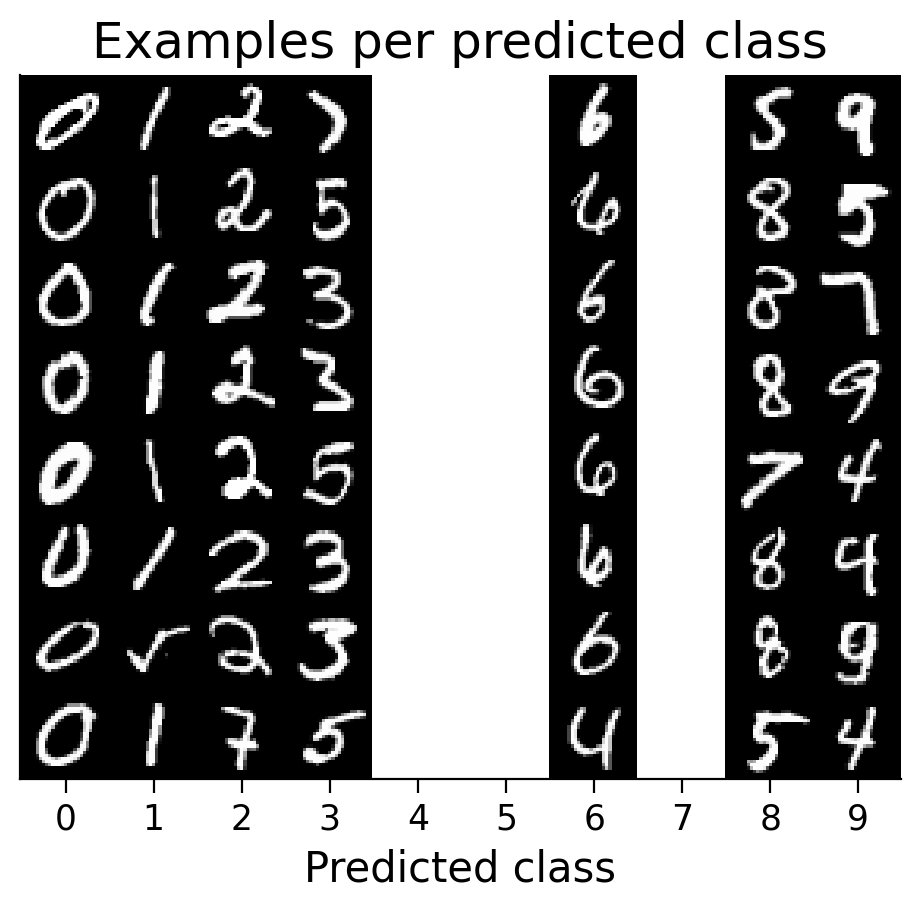

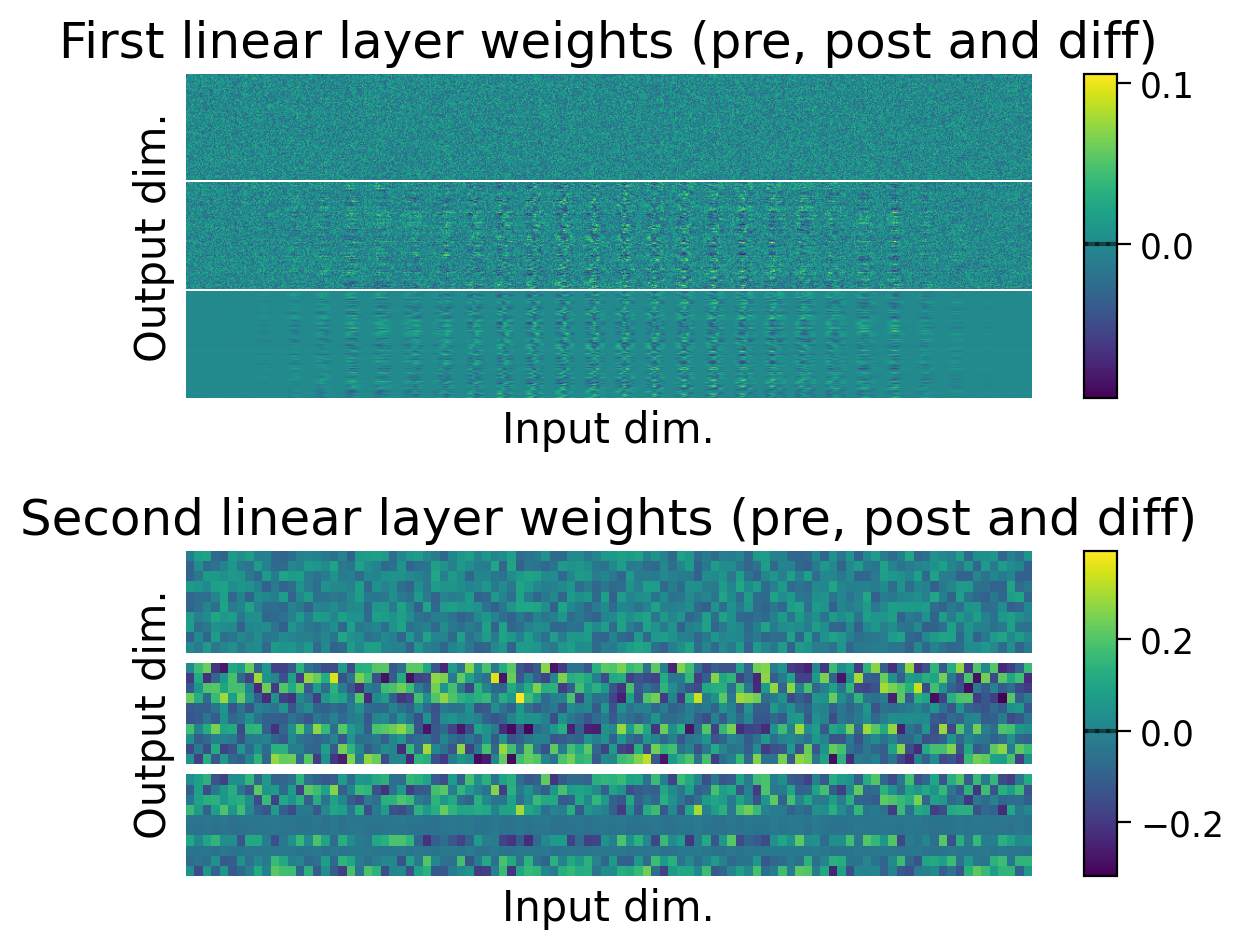

In [32]:
# @title Results

plot_results(FB_results_dict, num_classes=10)
plot_scores_per_class(FB_results_dict, num_classes=10)
plot_examples(valid_loader.dataset, MLP=FBMLP, num_classes=10)
plot_weights(FBMLP);

print_results_by_class(FB_results_dict, dataset="train")
print_results_by_class(FB_results_dict, dataset="valid")
_ = test_model(FBMLP, test_loader)

len(imgs_o)=10
features gathered for: ['lin1', 'lin2']


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


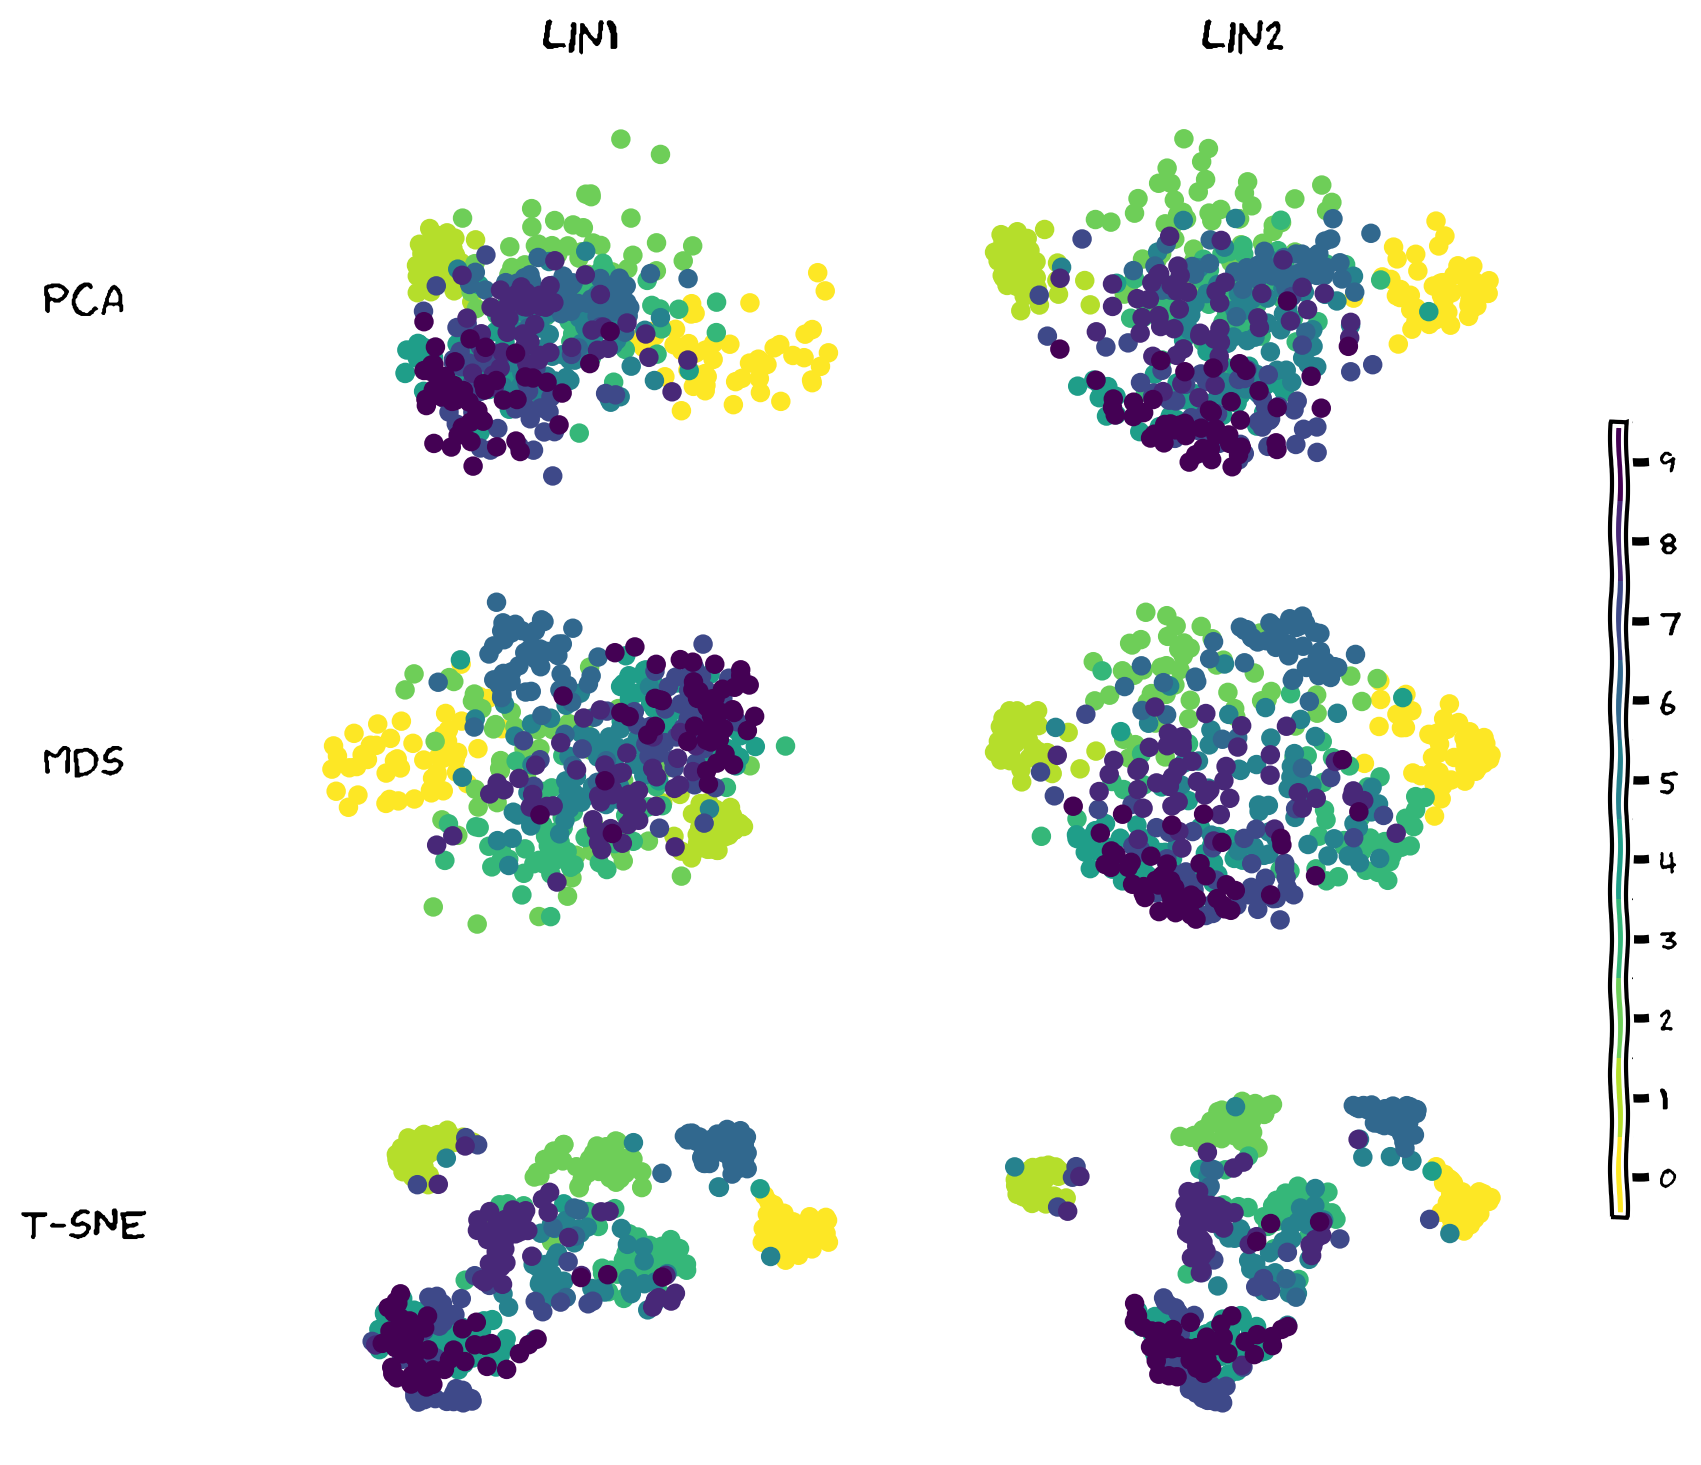

In [33]:
# @title Sequential image representation clustering

return_layers = ['lin1', 'lin2']
imgs, labels = sample_images(test_loader, n=50) #grab 50 samples from the each category

model_features = extract_features(FBMLP, imgs.to('cuda'), return_layers)
print('features gathered for:', list(model_features.keys()))
plot_dim_reduction(model_features, labels, transformer_funcs =['PCA', 'MDS', 't-SNE'])

In [34]:
# @title Test on Adversarial Data

# Sample images and their corresponding targets
print("Sampling images from the test loader...")
imgs, targets = sample_images(test_loader, n=20, plot=False)

# # Print the shapes of the sampled images and targets for verification
# print(f'Image Tensor Shape: {imgs.shape}')
# print(f'Target Tensor Shape: {targets.shape}')

# Generate adversarial images from the sampled images
print("Generating adversarial images...")
adv_imgs = generate_adversarial(FBMLP, imgs, targets, epsilon=0.2)
print("Adversarial images generated.")

# Test the model on the adversarial images
print("Testing the model on adversarial images...")
test_adversarial(FBMLP, adv_imgs, targets)


Sampling images from the test loader...
len(imgs_o)=10
Generating adversarial images...
imgs.shape=torch.Size([200, 1, 28, 28])
Adversarial images generated.
Testing the model on adversarial images...
adversarial test accuracy = 14 / 200 = 0.07
